In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout
import keras_tuner as kt 
import matplotlib.pyplot as plt

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")

# === 1. Dataset ===
data = {
    'Year': list(range(2008, 2023)),
    'Land_used(ha)': [
        380543, 391291, 389471, 308104, 338626,
        329303, 375216, 376530, 447204, 453470,
        442958, 396397, 366426, 362320, 336003
    ]
}
df = pd.DataFrame(data)

# === 2. Create lag features ===
def create_lag_features(series, window=3):
    X, y, years = [], [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
        years.append(df['Year'][i])
    return np.array(X), np.array(y), years

land_used_series = df['Land_used(ha)'].values
X_lag, y_lag, target_years = create_lag_features(land_used_series, window=3)
X_train, y_train = X_lag[:10], y_lag[:10]
X_test, y_test = X_lag[10:], y_lag[10:]
test_years = target_years[10:]

# === 3. Random Forest ===
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# === 4. XGBoost ===
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# === 5. ARIMA ===
arima_preds = []
full_series = list(land_used_series[:13])  # up to 2020

for i in range(2):  # predict 2021 & 2022
    model = ARIMA(full_series, order=(2, 1, 0))
    model_fit = model.fit()
    forecast = model_fit.forecast()[0]
    arima_preds.append(forecast)
    full_series.append(df['Land_used(ha)'][13 + i])

# === 6. Ensemble ===
ensemble_preds = (rf_preds + xgb_preds + arima_preds) / 3

# === 7. Evaluation ===
def evaluate_model(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

eval_results = {
    "ARIMA": evaluate_model(y_test, arima_preds),
    "Random Forest": evaluate_model(y_test, rf_preds),
    "XGBoost": evaluate_model(y_test, xgb_preds),
    "Ensemble": evaluate_model(y_test, ensemble_preds)
}
eval_df = pd.DataFrame(eval_results).T
print("📊 Evaluation Metrics:\n", eval_df)

# === 8. Prediction Table ===
predictions_table = pd.DataFrame({
    "Year": test_years,
    "Actual": y_test,
    "ARIMA": arima_preds,
    "Random Forest": rf_preds,
    "XGBoost": xgb_preds,
    "Ensemble": ensemble_preds
})
print("\n📅 Year-wise Predictions:\n", predictions_table)


📊 Evaluation Metrics:
                      R2          RMSE           MAE
ARIMA         -0.918486  18225.764464  14124.846541
Random Forest  0.244827  11434.825969  11321.500000
XGBoost       -0.686944  17090.574712  13144.187500
Ensemble       0.154249  12101.177073  11994.604123

📅 Year-wise Predictions:
    Year  Actual          ARIMA  Random Forest       XGBoost       Ensemble
0  2021  362320  364926.721672      352604.39  338252.53125  351927.880974
1  2022  336003  361645.971410      348930.39  338223.90625  349600.089220


In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

# === 1. Data ===
import pandas as pd

# === 1. Load from Excel ===
df = pd.read_excel("Australia.xlsx")

# === 2. Use only 'Year' and 'Land_used(ha)' columns ===
df = df[['Year', 'Land_used(ha)']].copy()

# (Optional) Sort by year just in case
df = df.sort_values('Year').reset_index(drop=True)

# Proceed with rest of the code unchanged
land_used = df['Land_used(ha)'].values
years = df['Year'].tolist()

df = pd.DataFrame(data)

# === 2. Create initial training data ===
def create_lag_features(series, window=3):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)'].values
X_train, y_train = create_lag_features(land_used[:13], window=3)  # up to 2010 → predict till 2020

# === 3. Train models ===
rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# === 4. Recursive prediction from 2011 to 2022 ===
years = list(df['Year'][3:])  # 2011–2022
actual = list(df['Land_used(ha)'][3:])

rf_preds, xgb_preds, arima_preds = [], [], []
series_rf = list(land_used[:3])  # starting with 2008–2010
series_arima = list(land_used[:3])

for _ in range(len(years)):
    # Random Forest & XGBoost
    input_seq = np.array(series_rf[-3:]).reshape(1, -1)
    rf_pred = rf.predict(input_seq)[0]
    xgb_pred = xgb.predict(input_seq)[0]
    rf_preds.append(rf_pred)
    xgb_preds.append(xgb_pred)
    series_rf.append(rf_pred)  # update for next iteration

    # ARIMA
    model = ARIMA(series_arima, order=(2, 1, 0))
    model_fit = model.fit()
    arima_pred = model_fit.forecast()[0]
    arima_preds.append(arima_pred)
    series_arima.append(arima_pred)

# === 5. Ensemble ===
ensemble_preds = (np.array(rf_preds) + np.array(xgb_preds) + np.array(arima_preds)) / 3

# === 6. Evaluation ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

results = {
    "ARIMA": evaluate(actual, arima_preds),
    "Random Forest": evaluate(actual, rf_preds),
    "XGBoost": evaluate(actual, xgb_preds),
    "Ensemble": evaluate(actual, ensemble_preds)
}
results_df = pd.DataFrame(results).T
print("\n📊 Evaluation Table:\n", results_df)

# === 7. Final Predictions ===
pred_table = pd.DataFrame({
    "Year": years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "Random Forest": rf_preds,
    "XGBoost": xgb_preds,
    "Ensemble": ensemble_preds
})
print("\n📅 Year-wise Prediction Table:\n", pred_table)



📊 Evaluation Table:
                      R2          RMSE           MAE
ARIMA         -0.062817  47989.542793  42100.136708
Random Forest  0.098321  44202.159327  36002.921667
XGBoost        0.323965  38273.836749  22877.481771
Ensemble       0.311988  38611.377271  32357.659175

📅 Year-wise Prediction Table:
     Year  Actual          ARIMA  Random Forest       XGBoost       Ensemble
0   2011  308104  389356.285687      353366.65  308104.12500  350275.686896
1   2012  338626  389407.042522      344158.71  338223.90625  357263.219591
2   2013  329303  389465.251315      340942.37  330823.90625  353743.842522
3   2014  375216  389471.475497      377506.06  375472.21875  380816.584749
4   2015  376530  389469.808831      404145.11  378998.78125  390871.233360
5   2016  447204  389469.257512      413120.11  447028.37500  416539.247504
6   2017  453470  389469.250702      400107.38  428215.03125  405930.553984
7   2018  442958  389469.277655      354969.97  338252.53125  360897.259635
8 

XGBoostError: [10:42:43] C:\actions-runner\_work\xgboost\xgboost\src\data\array_interface.h:499: Unicode-2 is not supported.

In [1]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean Data ===
df = pd.read_excel("Australia.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()

# Clean 'Land_used(ha)' column: remove commas, NBSPs, etc.
df['Land_used(ha)'] = (
    df['Land_used(ha)']
    .astype(str)
    .str.replace(',', '')
    .str.replace('\xa0', '')
    .astype(float)
)

# Sort and reset index
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Create Lag Features ===
def create_lag_features(series, window=3):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)'].values
years = df['Year'].tolist()

# Up to 2010 (index 3: 2008-2010), start predicting from 2011
X_train, y_train = create_lag_features(land_used[:13], window=3)  # 2008–2010 to predict 2011–2021

# === 4. Train Traditional Models ===
rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# === 5. Train LSTM & GRU ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
y_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

# LSTM
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(3,1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# GRU
model_gru = Sequential([
    GRU(50, activation='relu', input_shape=(3,1)),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# === 6. Recursive Prediction from 2011 to 2022 ===
series = list(land_used[:3])  # 2008–2010
actual = land_used[3:]       # 2011–2022
pred_years = years[3:]

rf_preds, xgb_preds, arima_preds, lstm_preds, gru_preds = [], [], [], [], []

for i in range(len(actual)):
    input_seq = np.array(series[-3:]).reshape(1, -1)
    
    # Random Forest & XGBoost
    rf_pred = rf.predict(input_seq)[0]
    xgb_pred = xgb.predict(input_seq)[0]
    
    # ARIMA
    model_arima = ARIMA(series, order=(2, 1, 0))
    model_fit = model_arima.fit()
    arima_pred = model_fit.forecast()[0]
    
    # LSTM & GRU
    input_seq = np.array(series[-3:]).reshape(-1, 1)  # shape: (3, 1)
    input_scaled = scaler.transform(input_seq).reshape((1, 3, 1))  # shape: (1, 3, 1)
    lstm_pred = scaler.inverse_transform(model_lstm.predict(input_scaled, verbose=0))[0][0]
    gru_pred = scaler.inverse_transform(model_gru.predict(input_scaled, verbose=0))[0][0]
    
    # Save predictions
    rf_preds.append(rf_pred)
    xgb_preds.append(xgb_pred)
    arima_preds.append(arima_pred)
    lstm_preds.append(lstm_pred)
    gru_preds.append(gru_pred)
    
    # Update sequence for next iteration
    series.append(rf_pred)  # You can use ensemble instead here if you want

# === 7. Ensemble (average) ===
ensemble_preds = (
    np.array(rf_preds) +
    np.array(xgb_preds) +
    np.array(arima_preds) +
    np.array(lstm_preds) +
    np.array(gru_preds)
) / 5

# === 8. Evaluation Function ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

# === 9. Evaluation Table ===
results = {
    "ARIMA": evaluate(actual, arima_preds),
    "Random Forest": evaluate(actual, rf_preds),
    "XGBoost": evaluate(actual, xgb_preds),
    "LSTM": evaluate(actual, lstm_preds),
    "GRU": evaluate(actual, gru_preds),
    "Ensemble": evaluate(actual, ensemble_preds)
}
results_df = pd.DataFrame(results).T
print("\n Model Evaluation Table:\n", results_df)

# === 10. Year-wise Prediction Table ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "Random Forest": rf_preds,
    "XGBoost": xgb_preds,
    "LSTM": lstm_preds,
    "GRU": gru_preds,
    "Ensemble": ensemble_preds
})
desired_order = ["Year", "Actual", "ARIMA", "Random Forest", "XGBoost", "LSTM", "GRU", "Ensemble"]
pred_table = pred_table[desired_order]

print("\n Year-wise Prediction Table:\n", pred_table.to_string(index=False))




 Model Evaluation Table:
                      R2          RMSE           MAE
ARIMA          0.211832  41297.418408  36517.720820
Random Forest  0.092187  44321.196844  36011.810833
XGBoost        0.325548  38202.236085  22720.502604
LSTM           0.148804  42916.891102  34527.098958
GRU            0.180327  42114.711956  33683.710938
Ensemble       0.344482  37662.191468  31500.913993

 Year-wise Prediction Table:
  Year   Actual         ARIMA  Random Forest      XGBoost         LSTM          GRU      Ensemble
 2011 308104.0 389356.285687      352646.77 308104.12500 383334.75000 382701.93750 363228.773637
 2012 338626.0 351590.219716      343178.33 338131.59375 378134.75000 372720.43750 356751.066193
 2013 329303.0 374731.673564      341313.60 330392.43750 371322.59375 368239.00000 357199.860963
 2014 375216.0 341329.907781      377033.79 375482.87500 365597.34375 367705.78125 365429.939556
 2015 376530.0 378160.844289      403451.51 378432.68750 369957.71875 376947.90625 381390.133

In [2]:
#Export to CSV
pred_table.to_csv("land_used_predictions.csv", index=False)
print("Prediction results saved to 'land_used_predictions.csv'")


Prediction results saved to 'land_used_predictions.csv'


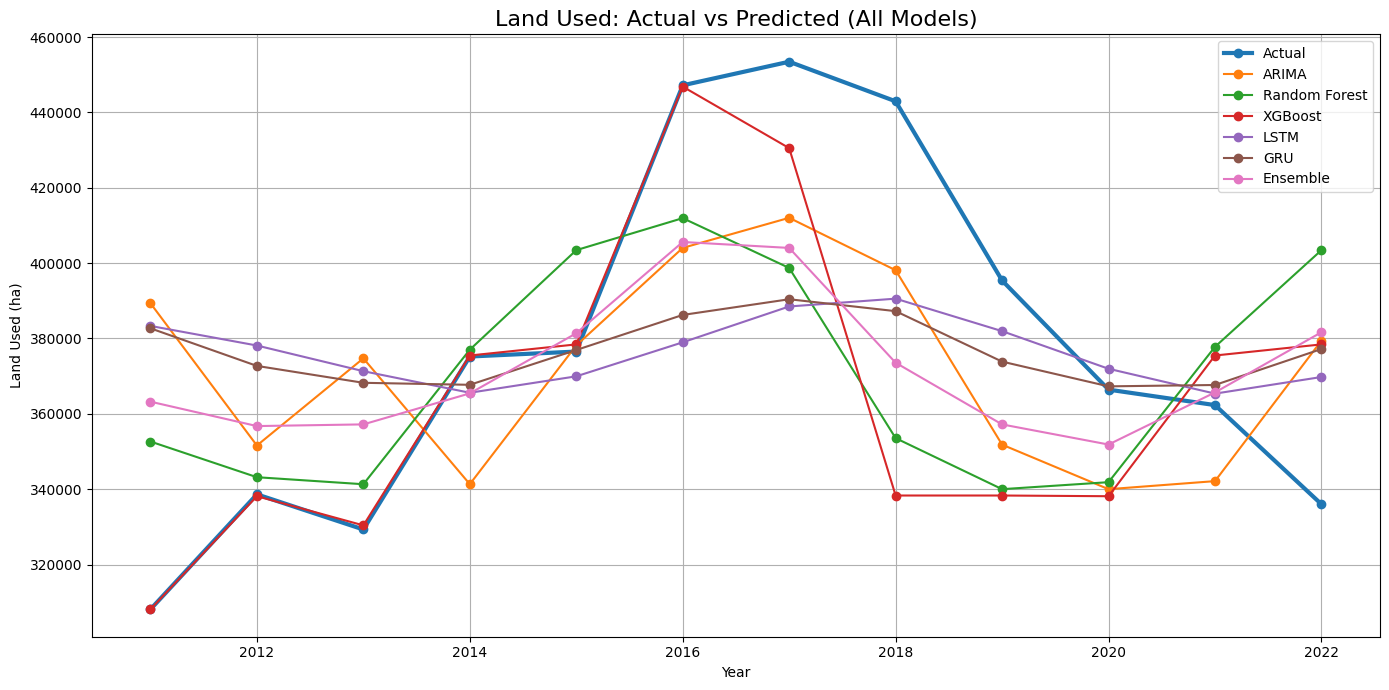

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(pred_table["Year"], pred_table["Actual"], label="Actual", marker='o', linewidth=3)
plt.plot(pred_table["Year"], pred_table["ARIMA"], label="ARIMA", marker='o')
plt.plot(pred_table["Year"], pred_table["Random Forest"], label="Random Forest", marker='o')
plt.plot(pred_table["Year"], pred_table["XGBoost"], label="XGBoost", marker='o')
plt.plot(pred_table["Year"], pred_table["LSTM"], label="LSTM", marker='o')
plt.plot(pred_table["Year"], pred_table["GRU"], label="GRU", marker='o')
plt.plot(pred_table["Year"], pred_table["Ensemble"], label="Ensemble", marker='o')

plt.title("Land Used: Actual vs Predicted (All Models)", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Land Used (ha)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


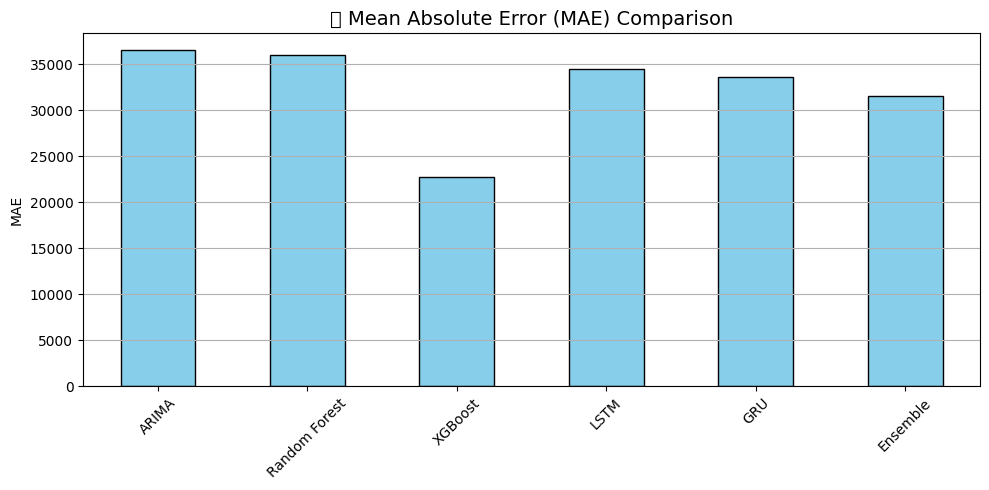

In [14]:
results_df["MAE"].plot(kind='bar', figsize=(10, 5), color='skyblue', edgecolor='black')
plt.title("🔍 Mean Absolute Error (MAE) Comparison", fontsize=14)
plt.ylabel("MAE")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [1]:
#Stacking Ensemble

# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean Data ===
df = pd.read_excel("Australia.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = (
    df['Land_used(ha)']
    .astype(str)
    .str.replace(',', '')
    .str.replace('\xa0', '')
    .astype(float)
)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Create Lag Features ===
def create_lag_features(series, window=3):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)'].values
years = df['Year'].tolist()
X_train, y_train = create_lag_features(land_used[:13], window=3)  # 2008–2010 → predict 2011–2021

# === 4. Train Base Models ===
rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# === 5. Train LSTM & GRU ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
y_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

# LSTM
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(3,1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# GRU
model_gru = Sequential([
    GRU(50, activation='relu', input_shape=(3,1)),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# === 6. Recursive Base Predictions for 2011–2022 ===
series = list(land_used[:3])  # Start from 2008–2010
actual = land_used[3:]       # Ground truth: 2011–2022
pred_years = years[3:]

rf_preds, xgb_preds, arima_preds, lstm_preds, gru_preds = [], [], [], [], []
stacked_features = []

for i in range(len(actual)):
    input_seq = np.array(series[-3:]).reshape(1, -1)

    # Random Forest & XGBoost
    rf_pred = rf.predict(input_seq)[0]
    xgb_pred = xgb.predict(input_seq)[0]

    # ARIMA
    model_arima = ARIMA(series, order=(2, 1, 0))
    model_fit = model_arima.fit()
    arima_pred = model_fit.forecast()[0]

    # LSTM & GRU
    input_seq_scaled = scaler.transform(np.array(series[-3:]).reshape(-1, 1)).reshape((1, 3, 1))
    lstm_pred = scaler.inverse_transform(model_lstm.predict(input_seq_scaled, verbose=0))[0][0]
    gru_pred = scaler.inverse_transform(model_gru.predict(input_seq_scaled, verbose=0))[0][0]

    # Save base model predictions
    rf_preds.append(rf_pred)
    xgb_preds.append(xgb_pred)
    arima_preds.append(arima_pred)
    lstm_preds.append(lstm_pred)
    gru_preds.append(gru_pred)

    # Collect features for stacking
    stacked_features.append([arima_pred, rf_pred, xgb_pred, lstm_pred, gru_pred])

    # Update sequence for next iteration (using rf_pred arbitrarily)
    series.append(rf_pred)

# === 7. Stacking: Train Meta Model ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
meta_model = LinearRegression()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)

# === 8. Evaluation Function ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

# === 9. Evaluation Table ===
results = {
    "ARIMA": evaluate(actual, arima_preds),
    "Random Forest": evaluate(actual, rf_preds),
    "XGBoost": evaluate(actual, xgb_preds),
    "LSTM": evaluate(actual, lstm_preds),
    "GRU": evaluate(actual, gru_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
results_df = pd.DataFrame(results).T
print("\nModel Evaluation Table:\n", results_df)

# === 10. Year-wise Prediction Table ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "Random Forest": rf_preds,
    "XGBoost": xgb_preds,
    "LSTM": lstm_preds,
    "GRU": gru_preds,
    "Stacked Ensemble": stacked_preds
})
print("\nYear-wise Prediction Table:\n", pred_table.to_string(index=False))



Model Evaluation Table:
                         R2          RMSE           MAE
ARIMA             0.211832  41297.418408  36517.720820
Random Forest     0.092187  44321.196844  36011.810833
XGBoost           0.325548  38202.236085  22720.502604
LSTM              0.148477  42925.117115  34547.130208
GRU               0.199589  41616.925377  33367.151042
Stacked Ensemble  0.798303  20891.197991  16950.083446

Year-wise Prediction Table:
  Year   Actual         ARIMA  Random Forest      XGBoost         LSTM          GRU  Stacked Ensemble
 2011 308104.0 389356.285687      352646.77 308104.12500 383232.93750 383253.18750     326908.852566
 2012 338626.0 351590.219716      343178.33 338131.59375 377909.93750 371930.87500     369624.275314
 2013 329303.0 374731.673564      341313.60 330392.43750 371405.96875 365712.46875     332098.482363
 2014 375216.0 341329.907781      377033.79 375482.87500 366252.25000 365133.34375     357485.424217
 2015 376530.0 378160.844289      403451.51 378432.687

In [3]:
# === 1. Imports ===
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean Data ===
df = pd.read_excel("Australia.xlsx")
df.columns = df.columns.str.strip()
df['Land_used(ha)'] = df['Land_used(ha)'].astype(str).str.replace(",", "").astype(float)
df = df.sort_values("Year").reset_index(drop=True)

# Predicted Land_used from Stage 1
land_used_pred = pred_table["Stacked Ensemble"].values
years_pred = pred_table["Year"].values
full_df = df[df["Year"].isin(years_pred)].reset_index(drop=True)

# Build prediction dataframe
pred_df = pd.DataFrame({
    "Year": years_pred,
    "Land_used(ha)": land_used_pred,
    "Actual_Yield": full_df["Sugarcane_Yield(t/ha)"].values,
    "Actual_Prod": full_df["Sugar_Prod(tons)"].values,
    "Actual_Export": full_df["Exported_sugar(tons)"].values
})

# === 3. Define Base Models ===
def get_base_models():
    return {
        "LinearRegression": LinearRegression(),
        "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
        "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
        "SVM": SVR(),
        "GradientBoost": GradientBoostingRegressor(n_estimators=100, random_state=42)
    }

# === 4. Evaluate Models and Train Stacking ===
def evaluate_models(X, y, stage_name):
    base_models = get_base_models()
    metrics = {}
    preds = {}

    for name, model in base_models.items():
        model.fit(X, y)
        y_pred = model.predict(X)
        preds[name] = y_pred
        metrics[name] = {
            "R2": round(r2_score(y, y_pred), 4),
            "RMSE": round(np.sqrt(mean_squared_error(y, y_pred)), 2),
            "MAE": round(mean_absolute_error(y, y_pred), 2)
        }

    # Stacking Regressor
    stack = StackingRegressor(
        estimators=[(name, mdl) for name, mdl in base_models.items()],
        final_estimator=LinearRegression()
    )
    stack.fit(X, y)
    y_stack = stack.predict(X)
    preds["Stacked"] = y_stack
    metrics["Stacked"] = {
        "R2": round(r2_score(y, y_stack), 4),
        "RMSE": round(np.sqrt(mean_squared_error(y, y_stack)), 2),
        "MAE": round(mean_absolute_error(y, y_stack), 2)
    }

    # Return predictions and metrics
    print(f"\n📊 {stage_name} - Evaluation of Models:")
    print(pd.DataFrame(metrics).T)
    return preds["Stacked"]

# === Stage 2: Predict Sugarcane Yield from Land Used ===
X2 = pred_df[['Land_used(ha)']]
y2 = pred_df['Actual_Yield']
pred_df["Pred_Yield"] = evaluate_models(X2, y2, "Stage 2 - Yield")

# === Stage 3: Predict Sugar Production from Land + Yield ===
X3 = pred_df[['Land_used(ha)', 'Pred_Yield']]
y3 = pred_df['Actual_Prod']
pred_df["Pred_Prod"] = evaluate_models(X3, y3, "Stage 3 - Production")

# === Stage 4: Predict Export from Land + Yield + Prod ===
X4 = pred_df[['Land_used(ha)', 'Pred_Yield', 'Pred_Prod']]
y4 = pred_df['Actual_Export']
pred_df["Pred_Export"] = evaluate_models(X4, y4, "Stage 4 - Export")

# === Final Prediction Table ===
print("\n🧾 Final Predictions (2022):")
print(pred_df[['Year', 'Land_used(ha)', 'Pred_Yield', 'Pred_Prod', 'Pred_Export']].tail(1).to_string(index=False))



📊 Stage 2 - Yield - Evaluation of Models:
                      R2  RMSE   MAE
LinearRegression  0.1912  3.03  2.58
RandomForest      0.7819  1.57  1.21
XGBoost           1.0000  0.00  0.00
SVM               0.1852  3.04  2.27
GradientBoost     1.0000  0.02  0.02
Stacked          -3.4355  7.10  5.68

📊 Stage 3 - Production - Evaluation of Models:
                      R2       RMSE        MAE
LinearRegression  0.7072  224364.64  183718.59
RandomForest      0.8592  155589.88  109223.33
XGBoost           1.0000       0.60       0.54
SVM              -0.0055  415779.01  325999.77
GradientBoost     1.0000     226.42     178.86
Stacked           0.0170  411098.07  296624.94

📊 Stage 4 - Export - Evaluation of Models:
                      R2       RMSE        MAE
LinearRegression  0.7335  190901.68  154708.81
RandomForest      0.8774  129495.67   90294.17
XGBoost           1.0000       0.44       0.35
SVM              -0.0681  382174.09  315333.24
GradientBoost     1.0000     106.63      8

In [7]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean Data ===
df = pd.read_excel("Australia_full.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = (
    df['Land_used(ha)']
    .astype(str)
    .str.replace(',', '')
    .str.replace('\xa0', '')
    .astype(float)
)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Create Lag Features (Sliding Window) ===
def create_lag_features(series, window=3):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)'].values
years = df['Year'].tolist()

# Use 2005-2007 to predict 2008-2022 => index 44 to 59
start_idx = years.index(2005)
X_train, y_train = create_lag_features(land_used[start_idx-3:start_idx+15], window=3)
pred_years = years[start_idx:start_idx+15]
actual = land_used[start_idx:start_idx+15]  # 2008–2022

# === 4. Train Base Models ===
rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# === 5. Train LSTM & GRU ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
y_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

# LSTM
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(3,1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# GRU
model_gru = Sequential([
    GRU(50, activation='relu', input_shape=(3,1)),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# === 6. Recursive Prediction for 2008–2022 ===
series = list(land_used[start_idx-3:start_idx])  # Start from 2005–2007

rf_preds, xgb_preds, arima_preds, lstm_preds, gru_preds = [], [], [], [], []
stacked_features = []

for i in range(15):  # Predict 2008 to 2022
    input_seq = np.array(series[-3:]).reshape(1, -1)

    # RF & XGB
    rf_pred = rf.predict(input_seq)[0]
    xgb_pred = xgb.predict(input_seq)[0]

    # ARIMA
    model_arima = ARIMA(series, order=(2, 1, 0))
    model_fit = model_arima.fit()
    arima_pred = model_fit.forecast()[0]

    # LSTM & GRU
    input_seq_scaled = scaler.transform(np.array(series[-3:]).reshape(-1, 1)).reshape((1, 3, 1))
    lstm_pred = scaler.inverse_transform(model_lstm.predict(input_seq_scaled, verbose=0))[0][0]
    gru_pred = scaler.inverse_transform(model_gru.predict(input_seq_scaled, verbose=0))[0][0]

    # Save predictions
    rf_preds.append(rf_pred)
    xgb_preds.append(xgb_pred)
    arima_preds.append(arima_pred)
    lstm_preds.append(lstm_pred)
    gru_preds.append(gru_pred)

    # For stacking
    stacked_features.append([arima_pred, rf_pred, xgb_pred, lstm_pred, gru_pred])

    # Update sequence for next prediction (here, using rf_pred arbitrarily)
    series.append(rf_pred)

# === 7. Stacking Ensemble ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
meta_model = LinearRegression()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)

# === 8. Evaluation Function ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

# === 9. Evaluation Table ===
results = {
    "ARIMA": evaluate(actual, arima_preds),
    "Random Forest": evaluate(actual, rf_preds),
    "XGBoost": evaluate(actual, xgb_preds),
    "LSTM": evaluate(actual, lstm_preds),
    "GRU": evaluate(actual, gru_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
results_df = pd.DataFrame(results).T
print("\n🔍 Model Evaluation Table:\n", results_df)

# === 10. Year-wise Predictions ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "Random Forest": rf_preds,
    "XGBoost": xgb_preds,
    "LSTM": lstm_preds,
    "GRU": gru_preds,
    "Stacked Ensemble": stacked_preds
})
print("\n📅 Year-wise Prediction Table:\n", pred_table.to_string(index=False))



🔍 Model Evaluation Table:
                         R2           RMSE           MAE
ARIMA            -5.083504  102632.747738  48607.073658
Random Forest     0.385189   32627.201040  25434.084000
XGBoost           0.401318   32196.400338  20151.035417
LSTM              0.204147   37121.502883  27309.560417
GRU               0.297299   34881.437235  26364.260417
Stacked Ensemble  0.681014   23501.475687  20032.058447

📅 Year-wise Prediction Table:
  Year   Actual         ARIMA  Random Forest      XGBoost         LSTM          GRU  Stacked Ensemble
 2005 433953.0 447527.225746      422539.58 433952.96875 409404.31250 414510.40625     470373.619466
 2006 397745.0 421226.978492      400530.03 397744.96875 409001.50000 407943.31250     413065.689892
 2007 408624.0 404679.752825      401760.12 402481.40625 401760.59375 398056.34375     390036.969005
 2008 380543.0      0.000000      386648.39 385767.28125 394841.09375 394632.12500     381122.298679
 2009 391291.0 385811.842248      371776.53

In [1]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean Data ===
df = pd.read_excel("Australia_full.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = (
    df['Land_used(ha)']
    .astype(str)
    .str.replace(',', '')
    .str.replace('\xa0', '')
    .astype(float)
)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Handle Outliers Using IQR Clipping ===
Q1 = df['Land_used(ha)'].quantile(0.25)
Q3 = df['Land_used(ha)'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df['Land_used(ha)'] = np.clip(df['Land_used(ha)'], lower, upper)

# === 4. Create Lag Features (Sliding Window) ===
def create_lag_features(series, window=3):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)'].values
years = df['Year'].tolist()

# Use 2005–2007 to predict 2008–2022
start_idx = years.index(2005)
X_train, y_train = create_lag_features(land_used[start_idx-3:start_idx+15], window=3)
pred_years = years[start_idx:start_idx+15]
actual = land_used[start_idx:start_idx+15]

# === 5. Train Base Models ===
rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# === 6. Train LSTM & GRU ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
y_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

# LSTM
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(3,1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# GRU
model_gru = Sequential([
    GRU(50, activation='relu', input_shape=(3,1)),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# === 7. Recursive Prediction for 2008–2022 ===
series = list(land_used[start_idx-3:start_idx])

rf_preds, xgb_preds, arima_preds, lstm_preds, gru_preds = [], [], [], [], []
stacked_features = []

for i in range(15):  # Predict 2008 to 2022
    input_seq = np.array(series[-3:]).reshape(1, -1)

    # RF & XGB
    rf_pred = rf.predict(input_seq)[0]
    xgb_pred = xgb.predict(input_seq)[0]

    # ARIMA
    model_arima = ARIMA(series, order=(2, 1, 0))
    model_fit = model_arima.fit()
    arima_pred = model_fit.forecast()[0]

    # LSTM & GRU
    input_seq_scaled = scaler.transform(np.array(series[-3:]).reshape(-1, 1)).reshape((1, 3, 1))
    lstm_pred = scaler.inverse_transform(model_lstm.predict(input_seq_scaled, verbose=0))[0][0]
    gru_pred = scaler.inverse_transform(model_gru.predict(input_seq_scaled, verbose=0))[0][0]

    # Save predictions
    rf_preds.append(rf_pred)
    xgb_preds.append(xgb_pred)
    arima_preds.append(arima_pred)
    lstm_preds.append(lstm_pred)
    gru_preds.append(gru_pred)

    # For stacking
    stacked_features.append([arima_pred, rf_pred, xgb_pred, lstm_pred, gru_pred])

    # Update input series (here using rf_pred arbitrarily)
    series.append(rf_pred)

# === 8. Stacking Ensemble ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
meta_model = LinearRegression()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)

# === 9. Evaluation Function ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

# === 10. Evaluation Table ===
results = {
    "ARIMA": evaluate(actual, arima_preds),
    "Random Forest": evaluate(actual, rf_preds),
    "XGBoost": evaluate(actual, xgb_preds),
    "LSTM": evaluate(actual, lstm_preds),
    "GRU": evaluate(actual, gru_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
results_df = pd.DataFrame(results).T
print("\n📊 Model Evaluation Table (with Outlier Handling):\n", results_df)

# === 11. Year-wise Prediction Table ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "Random Forest": rf_preds,
    "XGBoost": xgb_preds,
    "LSTM": lstm_preds,
    "GRU": gru_preds,
    "Stacked Ensemble": stacked_preds
})
print("\n📅 Year-wise Prediction Table:\n", pred_table.to_string(index=False))



📊 Model Evaluation Table (with Outlier Handling):
                         R2           RMSE           MAE
ARIMA            -5.083504  102632.747738  48607.073658
Random Forest     0.385189   32627.201040  25434.084000
XGBoost           0.401318   32196.400338  20151.035417
LSTM              0.233004   36442.287234  26612.743750
GRU               0.248826   36064.451327  26640.902083
Stacked Ensemble  0.663027   24154.987553  21211.875399

📅 Year-wise Prediction Table:
  Year   Actual         ARIMA  Random Forest      XGBoost         LSTM          GRU  Stacked Ensemble
 2005 433953.0 447527.225746      422539.58 433952.96875 412076.53125 411904.90625     473535.122164
 2006 397745.0 421226.978492      400530.03 397744.96875 410702.59375 408822.03125     415718.730403
 2007 408624.0 404679.752825      401760.12 402481.40625 403250.18750 400616.15625     390674.935679
 2008 380543.0      0.000000      386648.39 385767.28125 396917.50000 395494.84375     380931.526974
 2009 391291.0 3858

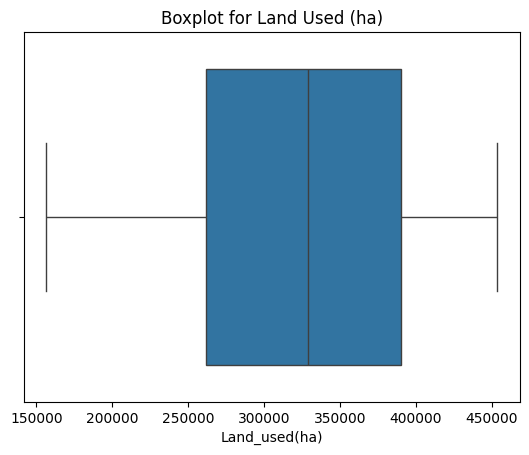

In [5]:
import seaborn as sns
sns.boxplot(x=df['Land_used(ha)'])
plt.title("Boxplot for Land Used (ha)")
plt.show()


In [ ]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean Data ===
df = pd.read_excel("Australia_full.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = df['Land_used(ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Handle Outliers Using IQR Clipping ===
Q1 = df['Land_used(ha)'].quantile(0.25)
Q3 = df['Land_used(ha)'].quantile(0.75)
IQR = Q3 - Q1
df['Land_used(ha)'] = np.clip(df['Land_used(ha)'], Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

# === 4. Create Lag Features ===
def create_lag_features(series, window=3):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)'].values
years = df['Year'].tolist()
start_idx = years.index(2005)
X_train, y_train = create_lag_features(land_used[start_idx-3:start_idx+15], window=3)
pred_years = years[start_idx:start_idx+15]
actual = land_used[start_idx:start_idx+15]

# === 5. Hyperparameter Tuning ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

models = {}

models['Random Forest'] = tune_model(RandomForestRegressor(random_state=42), {
    'n_estimators': [100, 200], 'max_depth': [None, 5, 10]
})

models['XGBoost'] = tune_model(XGBRegressor(random_state=42, verbosity=0), {
    'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
})

models['Decision Tree'] = tune_model(DecisionTreeRegressor(random_state=42), {
    'max_depth': [3, 5, 10]
})

models['SVM'] = tune_model(SVR(), {
    'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']
})

models['Gradient Boost'] = tune_model(GradientBoostingRegressor(random_state=42), {
    'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
})

# === 6. Train LSTM & GRU ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
y_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(3,1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

model_gru = Sequential([GRU(50, activation='relu', input_shape=(3,1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# === 7. Recursive Forecast ===
series = list(land_used[start_idx-3:start_idx])
preds = {name: [] for name in models}
arima_preds, lstm_preds, gru_preds = [], [], []
stacked_features = []

for _ in range(15):  # Predict 2008 to 2022
    input_seq = np.array(series[-3:]).reshape(1, -1)

    pred_row = []

    # Classical ML Models
    for name, model in models.items():
        pred = model.predict(input_seq)[0]
        preds[name].append(pred)
        pred_row.append(pred)

    # ARIMA
    model_arima = ARIMA(series, order=(2, 1, 0))
    arima_pred = model_arima.fit().forecast()[0]
    arima_preds.append(arima_pred)
    pred_row.append(arima_pred)

    # LSTM & GRU
    input_seq_scaled = scaler.transform(np.array(series[-3:]).reshape(-1, 1)).reshape((1, 3, 1))
    lstm_pred = scaler.inverse_transform(model_lstm.predict(input_seq_scaled, verbose=0))[0][0]
    gru_pred = scaler.inverse_transform(model_gru.predict(input_seq_scaled, verbose=0))[0][0]
    lstm_preds.append(lstm_pred)
    gru_preds.append(gru_pred)
    pred_row.extend([lstm_pred, gru_pred])

    stacked_features.append(pred_row)
    series.append(pred_row[0])  # arbitrary update, could be mean(pred_row)

# === 8. Stacking Ensemble ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
meta_model = LinearRegression()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)

# === 9. Evaluation Function ===
def evaluate(y_true, y_pred):
    return {
        "R2": (r2_score(y_true,y_pred)),

        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

# === 10. Evaluation Table ===
results = {
    "ARIMA": evaluate(actual, arima_preds),
    "LSTM": evaluate(actual, lstm_preds),
    "GRU": evaluate(actual, gru_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
for name in preds:
    results[name] = evaluate(actual, preds[name])

results_df = pd.DataFrame(results).T
print("\n📊 Model Evaluation Table:\n", results_df)

# === 11. Year-wise Table ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "LSTM": lstm_preds,
    "GRU": gru_preds,
    "Stacked Ensemble": stacked_preds
})
for name in preds:
    pred_table[name] = preds[name]

print("\n📅 Year-wise Prediction Table:\n", pred_table.to_string(index=False))



📊 Model Evaluation Table:
                         R2          RMSE           MAE
ARIMA             0.436084  31247.574574  25346.813518
LSTM              0.240130  36272.609970  27348.458333
GRU               0.239638  36284.344544  26857.304167
Stacked Ensemble  0.676731  23658.699036  18976.762978
Random Forest     0.292562  34998.816187  27662.470333
XGBoost           0.487293  29795.008719  19873.785417
Decision Tree     0.217344  36812.439963  24749.233333
SVM               0.369716  33035.224215  25930.204928
Gradient Boost    0.165986  38001.071890  25223.549981

📅 Year-wise Prediction Table:
  Year   Actual         ARIMA         LSTM          GRU  Stacked Ensemble  Random Forest      XGBoost  Decision Tree           SVM  Gradient Boost
 2005 433953.0 447527.225746 414134.12500 411647.00000     476429.676028     422864.400 430717.25000     433953.000 420184.484315   433076.323905
 2006 397745.0 421568.887253 413331.81250 408598.12500     411713.311091     400267.200 398313.531


📊 Model Evaluation Table:
                         R2          RMSE           MAE
ARIMA            -0.170637  40333.930225  33908.279353
LSTM             -0.010018  37464.851645  31496.608991
GRU               0.009937  37092.899180  30926.310163
Stacked Ensemble  0.637306  22450.698053  19375.623204
Random Forest    -0.104733  39182.127022  30125.391188
XGBoost          -0.241849  41542.607932  33168.937550
Decision Tree    -0.618712  47429.029733  38011.714731
SVM              -0.001358  37303.879070  33324.383257
Gradient Boost    0.012110  37052.170060  30083.065240

📅 Year-wise Prediction Table:
  Year        Actual         ARIMA         LSTM          GRU  Stacked Ensemble  Random Forest      XGBoost  Decision Tree           SVM  Gradient Boost
 2008 380543.000000 447527.225746 407456.40625 405229.21875     396987.267620  395790.137465 397097.62500  395399.000000 408868.741750   396788.606405
 2009 391291.000000 404623.599847 404169.03125 398455.50000     381259.620211  379434.95

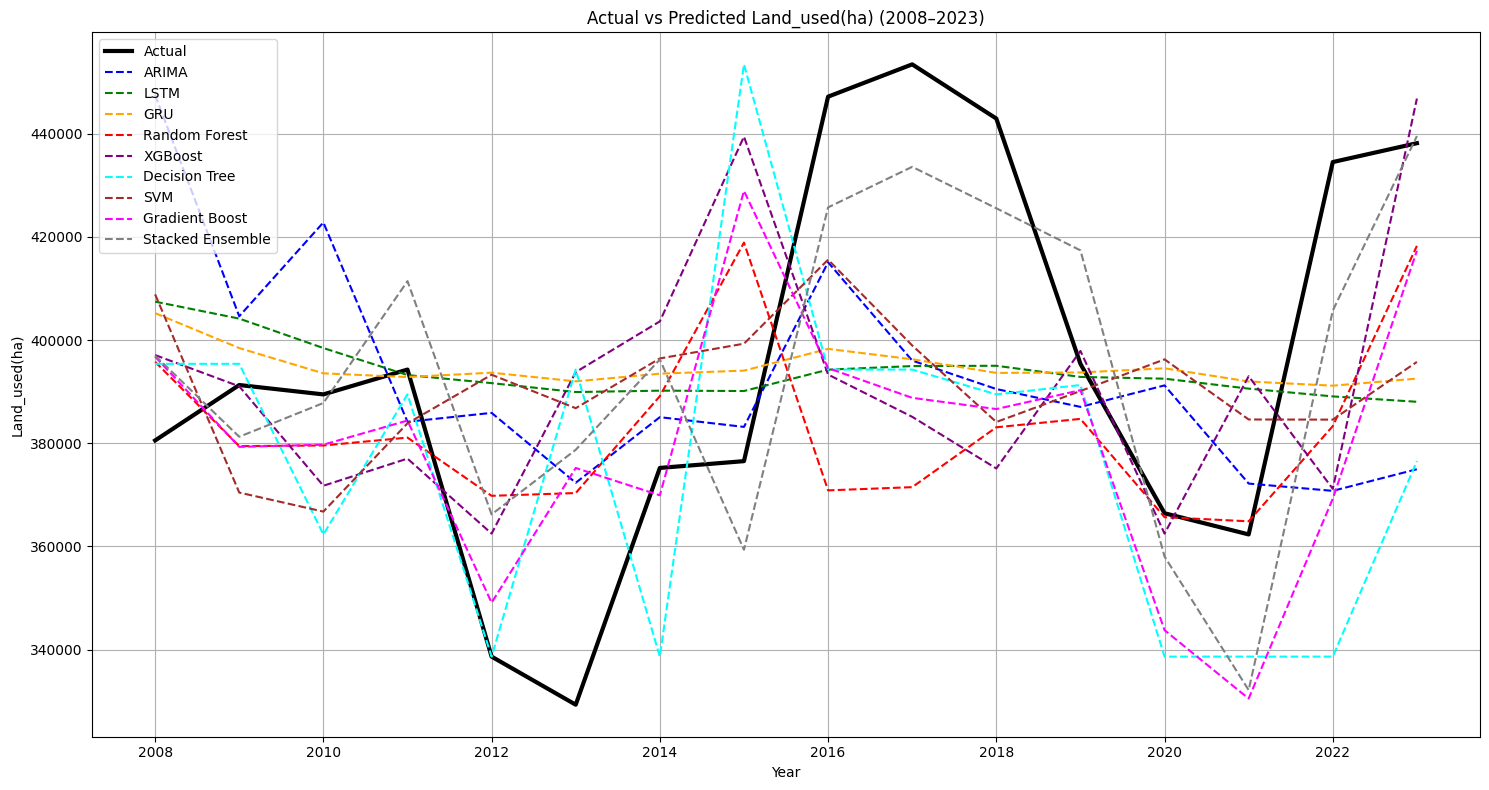

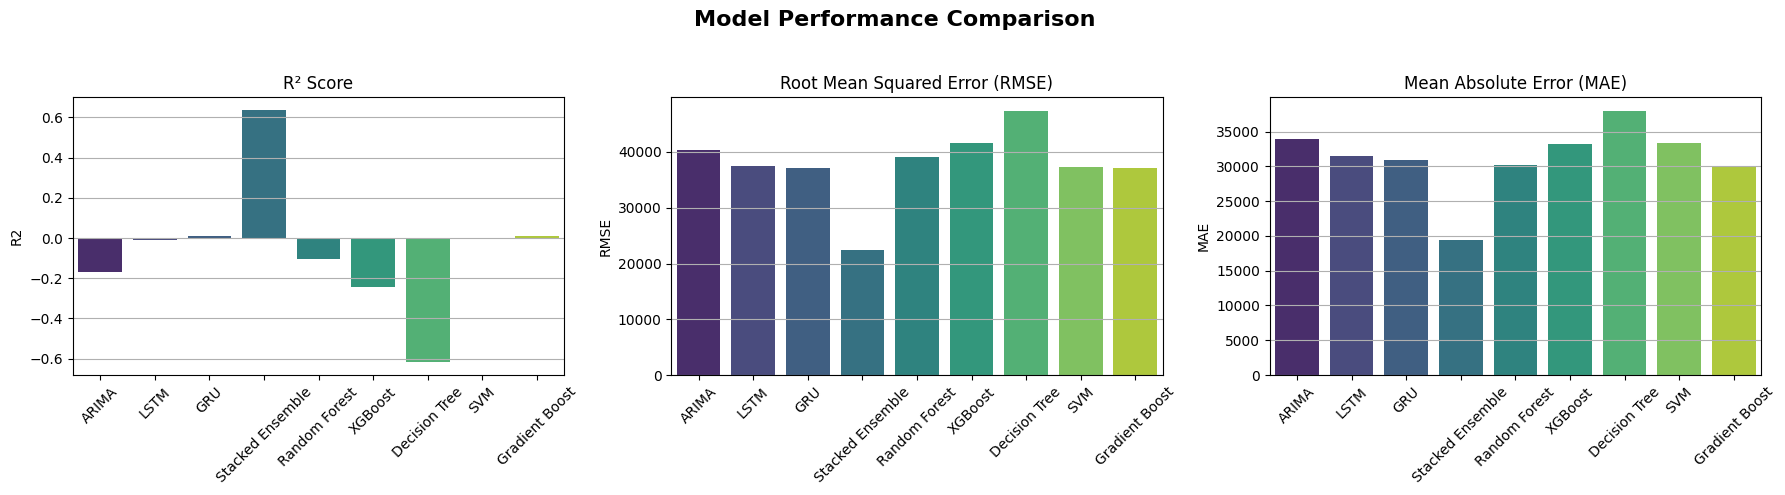

In [1]:
##FINAL STAGE 1

# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean Data ===
df = pd.read_excel("Australia_full.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = df['Land_used(ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Handle Outliers Using Best-Fit Regression Line ===
X_year = df[['Year']]
y_land = df['Land_used(ha)']
reg = LinearRegression()
reg.fit(X_year, y_land)
df['Predicted'] = reg.predict(X_year)
df['Residual'] = df['Land_used(ha)'] - df['Predicted']

# Define threshold for outlier: ±2 standard deviations from residuals
threshold = 2 * df['Residual'].std()
df['Outlier'] = df['Residual'].abs() > threshold

# Replace outliers with predicted values
df['Land_used(ha)'] = df.apply(
    lambda row: row['Predicted'] if row['Outlier'] else row['Land_used(ha)'],
    axis=1
)

# Drop temporary columns
df.drop(['Predicted', 'Residual', 'Outlier'], axis=1, inplace=True)


# === 4. Create Lag Features ===
def create_lag_features(series, window=3):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)'].values
years = df['Year'].tolist()
train_start = years.index(2005)  # Need 3 years before first prediction
train_end = years.index(2023) + 1  # inclusive end index

X_train, y_train = create_lag_features(land_used[train_start:train_end], window=3)
pred_years = years[train_start + 3:train_end]  # 2008 to 2023
actual = land_used[train_start + 3:train_end]



# === 5. Hyperparameter Tuning ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

models = {}

models['Random Forest'] = tune_model(RandomForestRegressor(random_state=42), {
    'n_estimators': [100, 200], 'max_depth': [None, 5, 10]
})

models['XGBoost'] = tune_model(XGBRegressor(random_state=42, verbosity=0), {
    'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
})

models['Decision Tree'] = tune_model(DecisionTreeRegressor(random_state=42), {
    'max_depth': [3, 5, 10]
})

models['SVM'] = tune_model(SVR(), {
    'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']
})

models['Gradient Boost'] = tune_model(GradientBoostingRegressor(random_state=42), {
    'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
})

# === 6. Train LSTM & GRU ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
y_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(3,1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

model_gru = Sequential([GRU(50, activation='relu', input_shape=(3,1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# === 7. Recursive Forecast (Improved) ===
series = list(land_used[train_start-3:train_start])  # Start from 3 values before 2005
preds = {name: [] for name in models}
arima_preds, lstm_preds, gru_preds = [], [], []
stacked_features = []

for _ in range(len(pred_years)):  # Predict from 2008 to 2023
    input_seq = np.array(series[-3:]).reshape(1, -1)
    pred_row = []

    # Classical ML Models
    for name, model in models.items():
        pred = model.predict(input_seq)[0]
        preds[name].append(pred)
        pred_row.append(pred)

    # ARIMA Prediction
    model_arima = ARIMA(series, order=(2, 1, 0))
    arima_pred = model_arima.fit().forecast()[0]
    arima_preds.append(arima_pred)
    pred_row.append(arima_pred)

    # LSTM Prediction
    input_seq_scaled = scaler.transform(np.array(series[-3:]).reshape(-1, 1)).reshape((1, 3, 1))
    lstm_pred = scaler.inverse_transform(model_lstm.predict(input_seq_scaled, verbose=0))[0][0]
    lstm_preds.append(lstm_pred)
    pred_row.append(lstm_pred)

    # GRU Prediction
    gru_pred = scaler.inverse_transform(model_gru.predict(input_seq_scaled, verbose=0))[0][0]
    gru_preds.append(gru_pred)
    pred_row.append(gru_pred)

    # Append full feature set for stacking model
    stacked_features.append(pred_row)

    # ✅ Use average of all model predictions to update input series
    series.append(np.mean(pred_row))

# === 8. Stacking Ensemble ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
meta_model = LinearRegression()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)

# === 9. Evaluation Function ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

# === 10. Evaluation Table ===
results = {
    "ARIMA": evaluate(actual, arima_preds),
    "LSTM": evaluate(actual, lstm_preds),
    "GRU": evaluate(actual, gru_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
for name in preds:
    results[name] = evaluate(actual, preds[name])

results_df = pd.DataFrame(results).T
print("\n📊 Model Evaluation Table:\n", results_df)

# === 11. Year-wise Prediction Table ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "LSTM": lstm_preds,
    "GRU": gru_preds,
    "Stacked Ensemble": stacked_preds
})
for name in preds:
    pred_table[name] = preds[name]

print("\n📅 Year-wise Prediction Table:\n", pred_table.to_string(index=False))

# === 12. Plot Actual vs Predictions for All Models ===
plt.figure(figsize=(15, 8))
plt.plot(pred_years, actual, label="Actual", linewidth=3, color='black')

colors = ['blue', 'green', 'orange', 'red', 'purple', 'cyan', 'brown', 'magenta', 'gray']
model_names = ['ARIMA', 'LSTM', 'GRU', 'Random Forest', 'XGBoost', 'Decision Tree', 'SVM', 'Gradient Boost', 'Stacked Ensemble']

for idx, name in enumerate(model_names):
    plt.plot(pred_years, pred_table[name], label=name, linestyle='--', color=colors[idx % len(colors)])

plt.xlabel("Year")
plt.ylabel("Land_used(ha)")
plt.title("Actual vs Predicted Land_used(ha) (2008–2023)")
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
plt.tight_layout()
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

# Reset index for better plotting
metrics_df = results_df.reset_index().rename(columns={'index': 'Model'})

# === 15. Combined Triple Bar Plot for R2, RMSE, MAE ===
plt.figure(figsize=(18, 5))
metrics = ['R2', 'RMSE', 'MAE']
titles = ['R² Score', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)']
colors = sns.color_palette("viridis", len(metrics_df))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    sns.barplot(x='Model', y=metric, data=metrics_df, palette=colors)
    plt.title(titles[i])
    plt.xticks(rotation=45)
    plt.xlabel(None)
    plt.ylabel(metric)
    plt.grid(True, axis='y')

plt.suptitle("Model Performance Comparison", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()





📊 Model Evaluation Table:
                         R2          RMSE           MAE
ARIMA            -0.011161  39785.908439  35393.460696
LSTM              0.008513  39396.944829  36122.035956
GRU              -0.002456  39614.291077  36058.759170
Stacked Ensemble  1.000000      4.817090      3.133710
Random Forest     0.129305  36919.196598  34252.897502
XGBoost          -0.322491  45500.436743  39664.361849
Decision Tree    -0.218906  43682.176832  34591.496894
SVM              -0.002818  39621.427778  36259.838021
Gradient Boost   -0.337599  45759.580345  35696.136625

📅 Year-wise Prediction Table:
  Year        Actual         ARIMA         LSTM          GRU  Stacked Ensemble  Random Forest      XGBoost  Decision Tree           SVM  Gradient Boost
 2010 362955.333333 431336.312272 394439.84375 409135.12500     362959.251354  397433.969300 391599.87500  401594.333333 387184.838918   394286.718102
 2011 345400.333333 400502.464323 391007.81250 397109.68750     345401.653374  384799.52

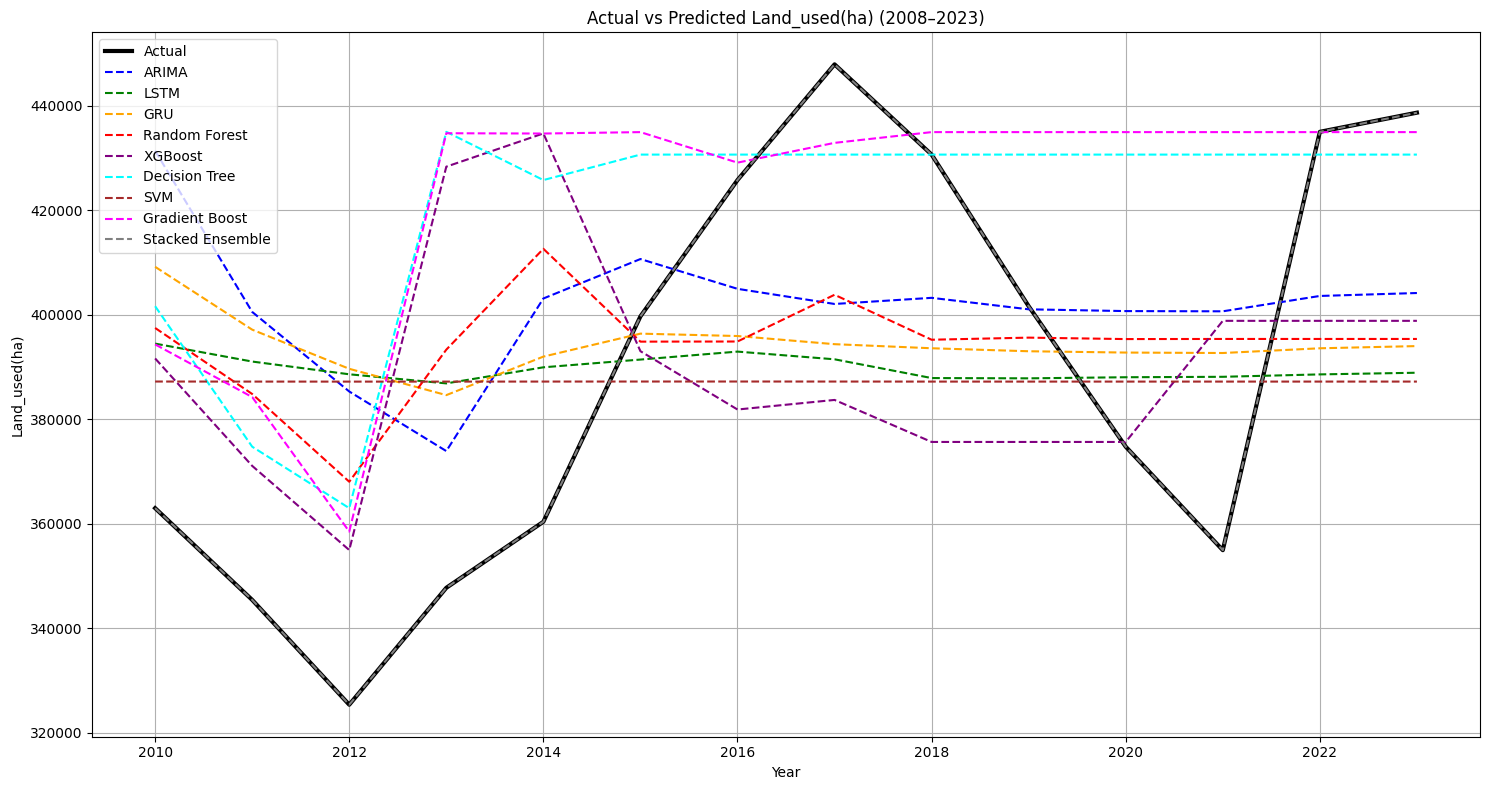

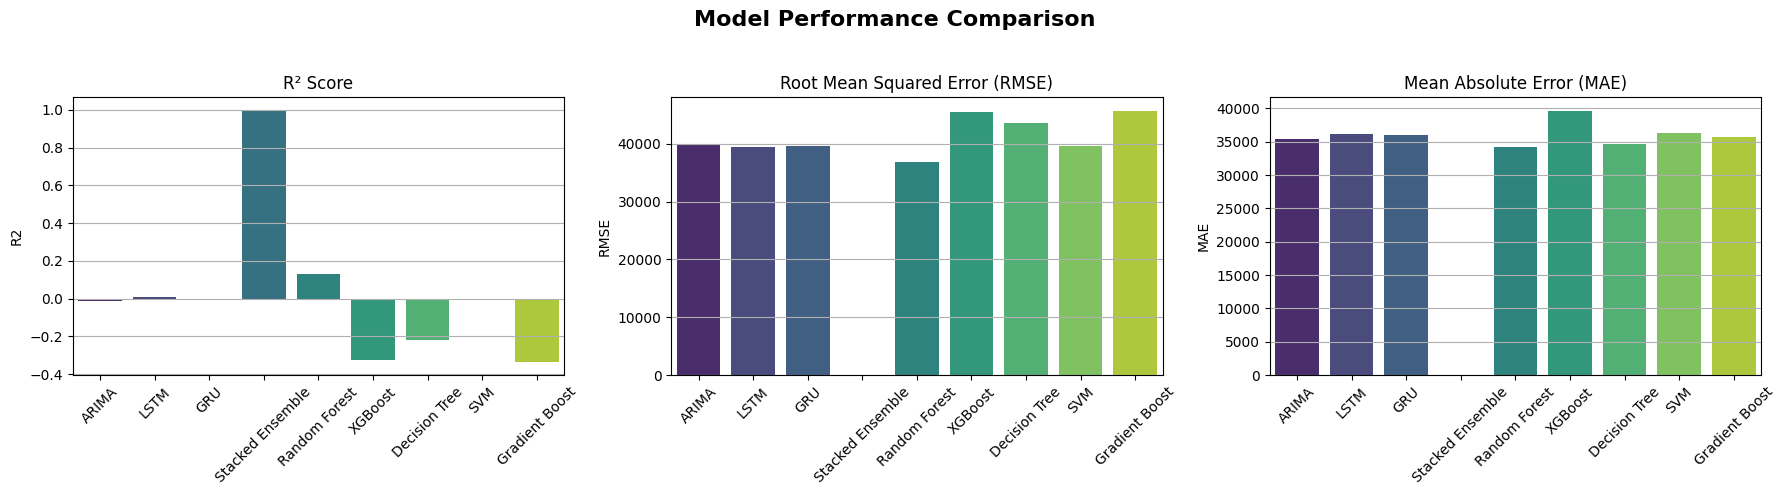

In [2]:
##FINAL STAGE 1

# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean Data ===
df = pd.read_excel("Australia_full.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = df['Land_used(ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 2.5. Apply Rolling Smoothing ===
df['Land_used(ha)'] = df['Land_used(ha)'].rolling(window=3, center=True).mean().fillna(method='bfill').fillna(method='ffill')


# === 3. Handle Outliers Using Best-Fit Regression Line ===
X_year = df[['Year']]
y_land = df['Land_used(ha)']
reg = LinearRegression()
reg.fit(X_year, y_land)
df['Predicted'] = reg.predict(X_year)
df['Residual'] = df['Land_used(ha)'] - df['Predicted']

# Define threshold for outlier: ±2 standard deviations from residuals
threshold = 2 * df['Residual'].std()
df['Outlier'] = df['Residual'].abs() > threshold

# Replace outliers with predicted values
df['Land_used(ha)'] = df.apply(
    lambda row: row['Predicted'] if row['Outlier'] else row['Land_used(ha)'],
    axis=1
)

# Drop temporary columns
df.drop(['Predicted', 'Residual', 'Outlier'], axis=1, inplace=True)


# === 4. Create Lag Features (Updated to window=5) ===
def create_lag_features(series, window=5):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)'].values
years = df['Year'].tolist()
train_start = years.index(2005)
train_end = years.index(2023) + 1

X_train, y_train = create_lag_features(land_used[train_start:train_end], window=5)
pred_years = years[train_start + 5:train_end]
actual = land_used[train_start + 5:train_end]




# === 5. Hyperparameter Tuning ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

models = {}

models['Random Forest'] = tune_model(RandomForestRegressor(random_state=42), {
    'n_estimators': [100, 200], 'max_depth': [None, 5, 10]
})

models['XGBoost'] = tune_model(XGBRegressor(random_state=42, verbosity=0), {
    'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
})

models['Decision Tree'] = tune_model(DecisionTreeRegressor(random_state=42), {
    'max_depth': [3, 5, 10]
})

models['SVM'] = tune_model(SVR(), {
    'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']
})

models['Gradient Boost'] = tune_model(GradientBoostingRegressor(random_state=42), {
    'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
})

# === 6. Train LSTM & GRU (Input shape = 5) ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
y_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(5,1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_scaled.reshape(-1, 5, 1), y_scaled, epochs=100, verbose=0)

model_gru = Sequential([GRU(50, activation='relu', input_shape=(5,1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_scaled.reshape(-1, 5, 1), y_scaled, epochs=100, verbose=0)


# === 7. Recursive Forecast (Updated for window=5) ===
series = list(land_used[train_start-5:train_start])
preds = {name: [] for name in models}
arima_preds, lstm_preds, gru_preds = [], [], []
stacked_features = []

for _ in range(len(pred_years)):  # Predict from 2008 to 2023
    input_seq = np.array(series[-5:]).reshape(1, -1)
    pred_row = []

    # Classical ML Models
    for name, model in models.items():
        pred = model.predict(input_seq)[0]
        preds[name].append(pred)
        pred_row.append(pred)

    # ARIMA
    model_arima = ARIMA(series, order=(2, 1, 0))
    arima_pred = model_arima.fit().forecast()[0]
    arima_preds.append(arima_pred)
    pred_row.append(arima_pred)

    # LSTM
    input_seq_scaled = scaler.transform(np.array(series[-5:]).reshape(-1, 1)).reshape((1, 5, 1))
    lstm_pred = scaler.inverse_transform(model_lstm.predict(input_seq_scaled, verbose=0))[0][0]
    lstm_preds.append(lstm_pred)
    pred_row.append(lstm_pred)

    # GRU
    gru_pred = scaler.inverse_transform(model_gru.predict(input_seq_scaled, verbose=0))[0][0]
    gru_preds.append(gru_pred)
    pred_row.append(gru_pred)

    stacked_features.append(pred_row)
    series.append(np.mean(pred_row))  # or use weighted avg

# === 8. Stacking Ensemble (using GradientBoostingRegressor) ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
from sklearn.ensemble import GradientBoostingRegressor
meta_model = GradientBoostingRegressor()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)


# === 9. Evaluation Function ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

# === 10. Evaluation Table ===
results = {
    "ARIMA": evaluate(actual, arima_preds),
    "LSTM": evaluate(actual, lstm_preds),
    "GRU": evaluate(actual, gru_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
for name in preds:
    results[name] = evaluate(actual, preds[name])

results_df = pd.DataFrame(results).T
print("\n📊 Model Evaluation Table:\n", results_df)

# === 11. Year-wise Prediction Table ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "LSTM": lstm_preds,
    "GRU": gru_preds,
    "Stacked Ensemble": stacked_preds
})
for name in preds:
    pred_table[name] = preds[name]

print("\n📅 Year-wise Prediction Table:\n", pred_table.to_string(index=False))

# === 12. Plot Actual vs Predictions for All Models ===
plt.figure(figsize=(15, 8))
plt.plot(pred_years, actual, label="Actual", linewidth=3, color='black')

colors = ['blue', 'green', 'orange', 'red', 'purple', 'cyan', 'brown', 'magenta', 'gray']
model_names = ['ARIMA', 'LSTM', 'GRU', 'Random Forest', 'XGBoost', 'Decision Tree', 'SVM', 'Gradient Boost', 'Stacked Ensemble']

for idx, name in enumerate(model_names):
    plt.plot(pred_years, pred_table[name], label=name, linestyle='--', color=colors[idx % len(colors)])

plt.xlabel("Year")
plt.ylabel("Land_used(ha)")
plt.title("Actual vs Predicted Land_used(ha) (2008–2023)")
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
plt.tight_layout()
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

# Reset index for better plotting
metrics_df = results_df.reset_index().rename(columns={'index': 'Model'})

# === 15. Combined Triple Bar Plot for R2, RMSE, MAE ===
plt.figure(figsize=(18, 5))
metrics = ['R2', 'RMSE', 'MAE']
titles = ['R² Score', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)']
colors = sns.color_palette("viridis", len(metrics_df))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    sns.barplot(x='Model', y=metric, data=metrics_df, palette=colors)
    plt.title(titles[i])
    plt.xticks(rotation=45)
    plt.xlabel(None)
    plt.ylabel(metric)
    plt.grid(True, axis='y')

plt.suptitle("Model Performance Comparison", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()





📊 Model Evaluation Table:
                         R2          RMSE           MAE
ARIMA             0.001855  39604.114481  35280.220891
LSTM             -0.097083  41520.556031  35948.451073
GRU               0.002828  39584.798786  34605.239020
Stacked Ensemble  1.000000     11.042097      9.732341
Random Forest     0.051092  38614.962514  32896.152283
XGBoost          -0.076251  41124.458163  34675.700454
Decision Tree     0.240292  34551.484381  29458.098395
SVM              -0.010765  39853.694327  33438.117505
Gradient Boost    0.131444  36943.859938  32896.935594

📅 Year-wise Prediction Table:
  Year        Actual         ARIMA         LSTM          GRU  Stacked Ensemble  Random Forest      XGBoost  Decision Tree           SVM  Gradient Boost
 2010 389471.000000 426661.567891 406166.06250 409922.68750     389481.434562  396290.109498 385459.06250  394843.029082 391880.323162   395179.727935
 2011 394287.058164 402335.477624 402209.03125 400301.96875     394270.943158  391673.79

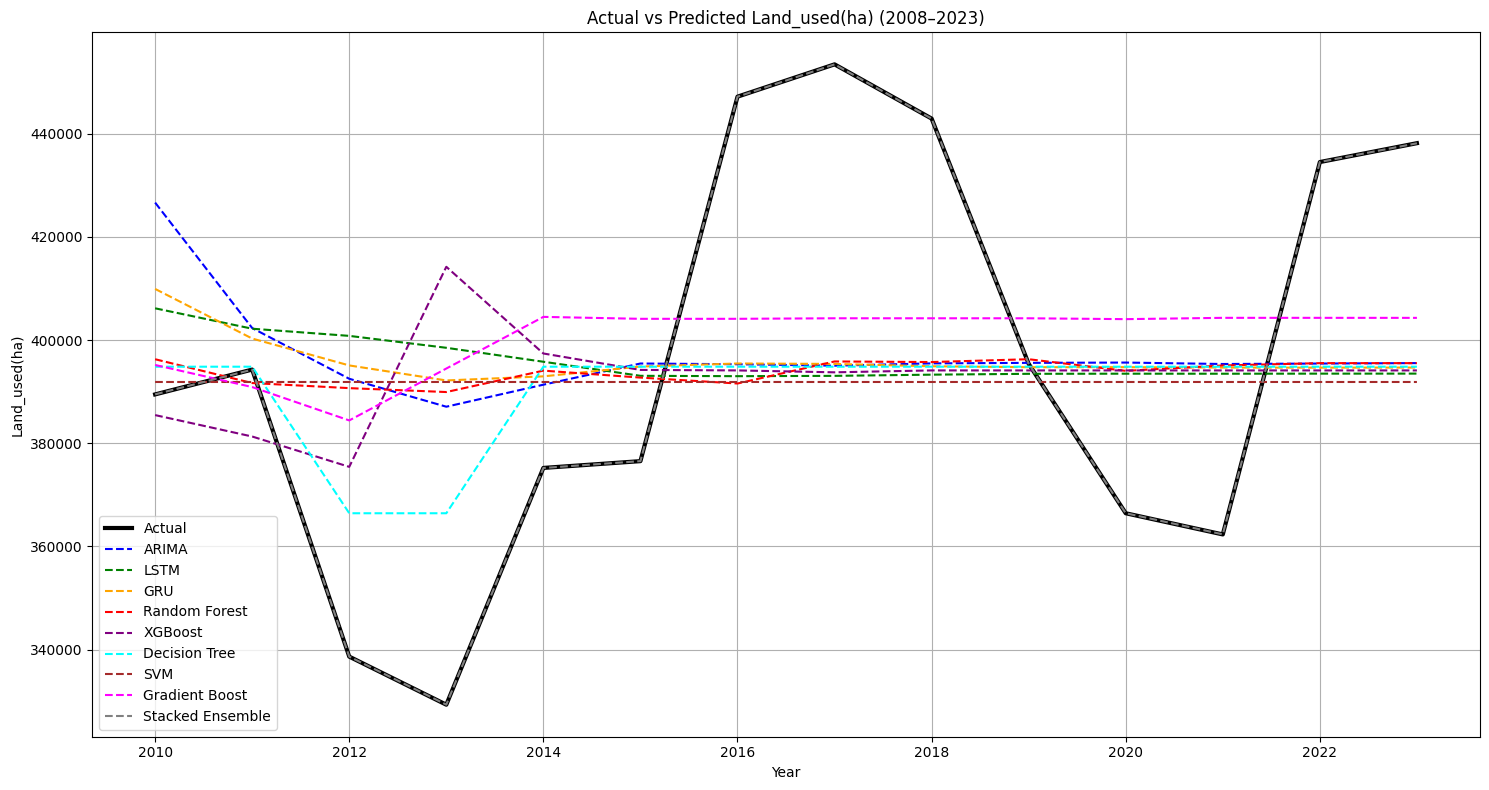

In [3]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import warnings
warnings.filterwarnings("ignore")

# === 2. Load Data ===
df = pd.read_excel("Australia_full.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = df['Land_used(ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Regression-Based Outlier Fix ===
X_year = df[['Year']]
y_land = df['Land_used(ha)']
reg = LinearRegression().fit(X_year, y_land)
df['Residual'] = y_land - reg.predict(X_year)
threshold = 2 * df['Residual'].std()
df['Land_used(ha)'] = df.apply(
    lambda row: reg.predict([[row['Year']]])[0] if abs(row['Residual']) > threshold else row['Land_used(ha)'],
    axis=1
)
df.drop(['Residual'], axis=1, inplace=True)

# === 4. Smoothing + Extra Features ===
df['RollingMean'] = df['Land_used(ha)'].rolling(window=3).mean()
df['RollingStd'] = df['Land_used(ha)'].rolling(window=3).std()
df['RollingMean'].fillna(method='bfill', inplace=True)
df['RollingStd'].fillna(method='bfill', inplace=True)
df['Year_norm'] = (df['Year'] - df['Year'].min()) / (df['Year'].max() - df['Year'].min())

# === 5. Create Lag Features ===
def create_lag_features(data, target_col, window=5):
    X, y = [], []
    for i in range(window, len(data)):
        row = []
        # lag values
        row.extend(data[target_col].iloc[i-window:i].values)
        # other engineered features
        row.extend(data[['RollingMean', 'RollingStd', 'Year_norm']].iloc[i].values)
        X.append(row)
        y.append(data[target_col].iloc[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)']
years = df['Year'].tolist()
train_start = years.index(2005)
train_end = years.index(2023) + 1

X_train, y_train = create_lag_features(df.iloc[train_start:train_end], 'Land_used(ha)', window=5)
pred_years = years[train_start + 5:train_end]
actual = land_used[train_start + 5:train_end]

# === 6. Feature Scaling for ML Models ===
scaler_ml = StandardScaler()
X_train_scaled = scaler_ml.fit_transform(X_train)

# === 7. Hyperparameter Tuning ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train_scaled, y_train)
    return grid.best_estimator_

models = {}

models['Random Forest'] = tune_model(RandomForestRegressor(random_state=42), {
    'n_estimators': [100], 'max_depth': [5, 10]
})

models['XGBoost'] = tune_model(XGBRegressor(random_state=42, verbosity=0), {
    'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [3, 5]
})

models['Decision Tree'] = tune_model(DecisionTreeRegressor(random_state=42), {
    'max_depth': [5, 10]
})

models['SVM'] = tune_model(SVR(), {
    'C': [1], 'kernel': ['rbf']
})

models['Gradient Boost'] = tune_model(GradientBoostingRegressor(random_state=42), {
    'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [3]
})

# === 8. LSTM/GRU Training (same lag window 5) ===
scaler_seq = MinMaxScaler()
X_seq_scaled = scaler_seq.fit_transform(X_train[:, :5])
y_seq_scaled = scaler_seq.fit_transform(y_train.reshape(-1, 1))

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(5,1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_seq_scaled.reshape(-1, 5, 1), y_seq_scaled, epochs=100, verbose=0)

model_gru = Sequential([GRU(50, activation='relu', input_shape=(5,1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_seq_scaled.reshape(-1, 5, 1), y_seq_scaled, epochs=100, verbose=0)

# === 9. Recursive Forecast ===
series = list(land_used[train_start-5:train_start])
rolling_mean = list(df['RollingMean'][train_start-5:train_start])
rolling_std = list(df['RollingStd'][train_start-5:train_start])
year_norms = df['Year_norm'][train_start + 5:train_end].tolist()

preds = {name: [] for name in models}
arima_preds, lstm_preds, gru_preds = [], [], []
stacked_features = []

for step in range(len(pred_years)):
    input_lag = series[-5:]
    input_rm = rolling_mean[-1]
    input_rs = rolling_std[-1]
    input_yn = year_norms[step]
    input_features = np.array(input_lag + [input_rm, input_rs, input_yn]).reshape(1, -1)

    pred_row = []

    for name, model in models.items():
        pred = model.predict(scaler_ml.transform(input_features))[0]
        preds[name].append(pred)
        pred_row.append(pred)

    model_arima = ARIMA(series, order=(2,1,0))
    arima_pred = model_arima.fit().forecast()[0]
    arima_preds.append(arima_pred)
    pred_row.append(arima_pred)

    # LSTM
    input_seq_scaled = scaler_seq.transform(np.array(input_lag).reshape(-1, 1)).reshape((1, 5, 1))
    lstm_pred = scaler_seq.inverse_transform(model_lstm.predict(input_seq_scaled, verbose=0))[0][0]
    lstm_preds.append(lstm_pred)
    pred_row.append(lstm_pred)

    # GRU
    gru_pred = scaler_seq.inverse_transform(model_gru.predict(input_seq_scaled, verbose=0))[0][0]
    gru_preds.append(gru_pred)
    pred_row.append(gru_pred)

    stacked_features.append(pred_row)
    avg_pred = np.mean(pred_row)
    series.append(avg_pred)
    rolling_mean.append(np.mean(series[-3:]))
    rolling_std.append(np.std(series[-3:]))

# === 10. Stack Ensemble (Gradient Boost) ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
meta_model = GradientBoostingRegressor()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)

# === 11. Evaluation ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

results = {
    "ARIMA": evaluate(actual, arima_preds),
    "LSTM": evaluate(actual, lstm_preds),
    "GRU": evaluate(actual, gru_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
for name in preds:
    results[name] = evaluate(actual, preds[name])

results_df = pd.DataFrame(results).T
print("\n📊 Model Evaluation Table:\n", results_df)

# === 12. Year-wise Predictions ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "LSTM": lstm_preds,
    "GRU": gru_preds,
    "Stacked Ensemble": stacked_preds
})
for name in preds:
    pred_table[name] = preds[name]

print("\n📅 Year-wise Prediction Table:\n", pred_table.to_string(index=False))

# === 13. Plot ===
plt.figure(figsize=(15, 8))
plt.plot(pred_years, actual, label="Actual", linewidth=3, color='black')
colors = ['blue', 'green', 'orange', 'red', 'purple', 'cyan', 'brown', 'magenta', 'gray']
model_names = ['ARIMA', 'LSTM', 'GRU', 'Random Forest', 'XGBoost', 'Decision Tree', 'SVM', 'Gradient Boost', 'Stacked Ensemble']
for idx, name in enumerate(model_names):
    plt.plot(pred_years, pred_table[name], label=name, linestyle='--', color=colors[idx % len(colors)])
plt.xlabel("Year")
plt.ylabel("Land_used(ha)")
plt.title("Actual vs Predicted Land_used(ha) (2008–2023)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



📊 Model Evaluation Table:
                         R2          RMSE           MAE
ARIMA             0.050723  38622.467831  34125.270212
Stacked Ensemble  0.999999     45.568744     37.235114
Random Forest     0.090087  37813.191418  32131.100402
Decision Tree     0.229314  34800.232179  29074.382032
Gradient Boost    0.211041  35210.376396  31658.770549

📅 Year-wise Prediction Table:
  Year        Actual         ARIMA  Stacked Ensemble  Random Forest  Decision Tree  Gradient Boost
 2010 389471.000000 426661.567891     389425.363866  396290.109498  394843.029082   395179.727935
 2011 394287.058164 404697.526743     394274.603161  391673.793662  394843.029082   390893.625168
 2012 338626.000000 393735.445878     338623.415461  390686.783239  366426.000000   384424.824633
 2013 329303.000000 383805.211889     329362.214979  390054.521102  366426.000000   384559.815032
 2014 375216.000000 380725.542552     375215.785177  391808.459034  389471.000000   403430.187638
 2015 376530.000000 39

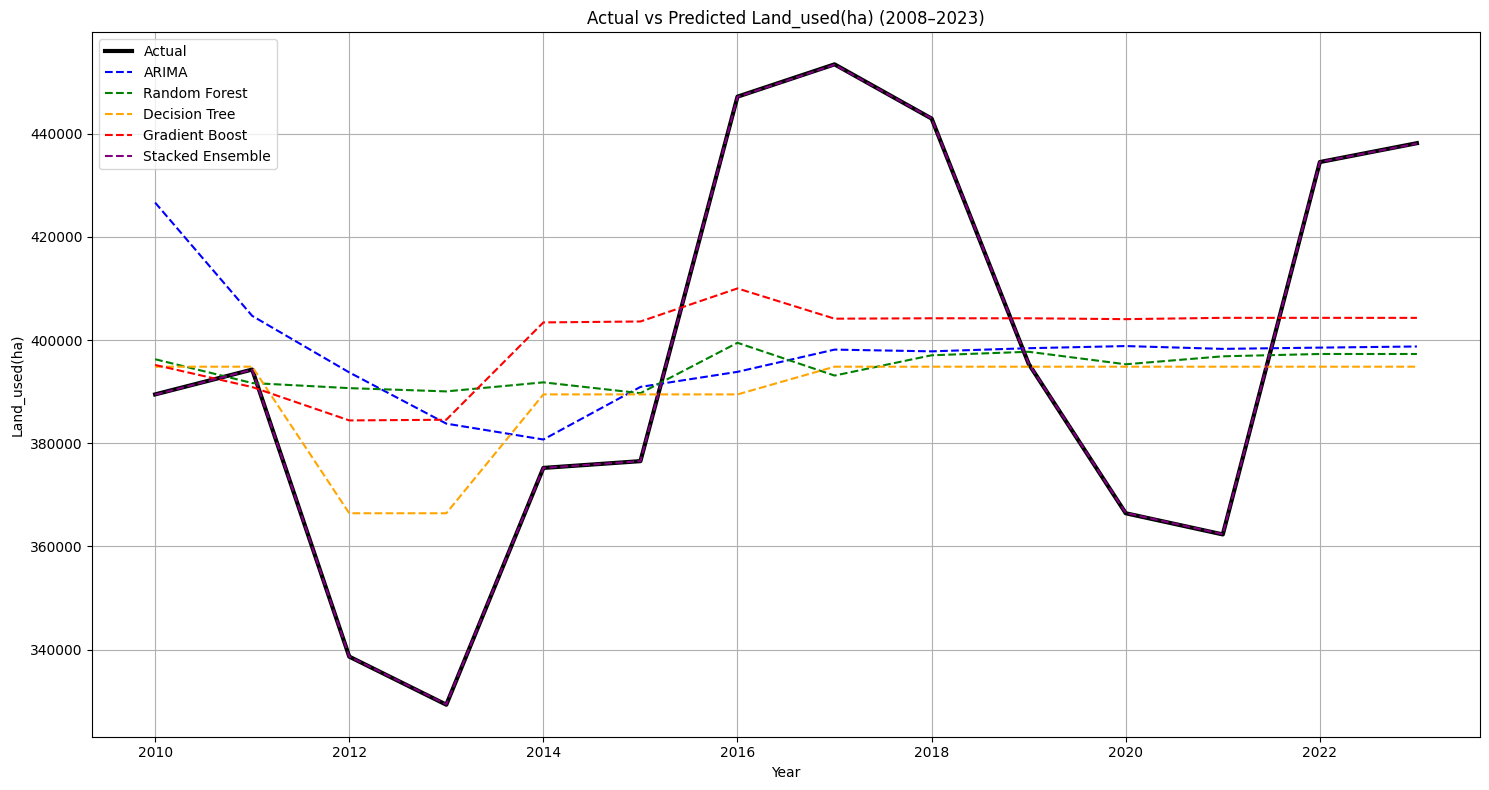

In [1]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

# === 2. Load Data ===
df = pd.read_excel("Australia_full.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = df['Land_used(ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Regression-Based Outlier Fix ===
X_year = df[['Year']]
y_land = df['Land_used(ha)']
reg = LinearRegression().fit(X_year, y_land)
df['Residual'] = y_land - reg.predict(X_year)
threshold = 2 * df['Residual'].std()
df['Land_used(ha)'] = df.apply(
    lambda row: reg.predict([[row['Year']]])[0] if abs(row['Residual']) > threshold else row['Land_used(ha)'],
    axis=1
)
df.drop(['Residual'], axis=1, inplace=True)

# === 4. Smoothing + Extra Features ===
df['RollingMean'] = df['Land_used(ha)'].rolling(window=3).mean()
df['RollingStd'] = df['Land_used(ha)'].rolling(window=3).std()
df['RollingMean'].fillna(method='bfill', inplace=True)
df['RollingStd'].fillna(method='bfill', inplace=True)
df['Year_norm'] = (df['Year'] - df['Year'].min()) / (df['Year'].max() - df['Year'].min())

# === 5. Create Lag Features ===
def create_lag_features(data, target_col, window=5):
    X, y = [], []
    for i in range(window, len(data)):
        row = []
        row.extend(data[target_col].iloc[i-window:i].values)
        row.extend(data[['RollingMean', 'RollingStd', 'Year_norm']].iloc[i].values)
        X.append(row)
        y.append(data[target_col].iloc[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)']
years = df['Year'].tolist()
train_start = years.index(2005)
train_end = years.index(2023) + 1

X_train, y_train = create_lag_features(df.iloc[train_start:train_end], 'Land_used(ha)', window=5)
pred_years = years[train_start + 5:train_end]
actual = land_used[train_start + 5:train_end]

# === 6. Feature Scaling ===
scaler_ml = StandardScaler()
X_train_scaled = scaler_ml.fit_transform(X_train)

# === 7. Hyperparameter Tuning ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train_scaled, y_train)
    return grid.best_estimator_

models = {}

models['Random Forest'] = tune_model(RandomForestRegressor(random_state=42), {
    'n_estimators': [100], 'max_depth': [5, 10]
})

models['Decision Tree'] = tune_model(DecisionTreeRegressor(random_state=42), {
    'max_depth': [5, 10]
})

models['Gradient Boost'] = tune_model(GradientBoostingRegressor(random_state=42), {
    'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [3]
})

# === 8. Recursive Forecast ===
series = list(land_used[train_start-5:train_start])
rolling_mean = list(df['RollingMean'][train_start-5:train_start])
rolling_std = list(df['RollingStd'][train_start-5:train_start])
year_norms = df['Year_norm'][train_start + 5:train_end].tolist()

preds = {name: [] for name in models}
arima_preds = []
stacked_features = []

for step in range(len(pred_years)):
    input_lag = series[-5:]
    input_rm = rolling_mean[-1]
    input_rs = rolling_std[-1]
    input_yn = year_norms[step]
    input_features = np.array(input_lag + [input_rm, input_rs, input_yn]).reshape(1, -1)

    pred_row = []

    for name, model in models.items():
        pred = model.predict(scaler_ml.transform(input_features))[0]
        preds[name].append(pred)
        pred_row.append(pred)

    model_arima = ARIMA(series, order=(2,1,0))
    arima_pred = model_arima.fit().forecast()[0]
    arima_preds.append(arima_pred)
    pred_row.append(arima_pred)

    stacked_features.append(pred_row)
    avg_pred = np.mean(pred_row)
    series.append(avg_pred)
    rolling_mean.append(np.mean(series[-3:]))
    rolling_std.append(np.std(series[-3:]))

# === 9. Stack Ensemble (Gradient Boost) ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
meta_model = GradientBoostingRegressor()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)

# === 10. Evaluation ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

results = {
    "ARIMA": evaluate(actual, arima_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
for name in preds:
    results[name] = evaluate(actual, preds[name])

results_df = pd.DataFrame(results).T
print("\n📊 Model Evaluation Table:\n", results_df)

# === 11. Year-wise Predictions ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "Stacked Ensemble": stacked_preds
})
for name in preds:
    pred_table[name] = preds[name]

print("\n📅 Year-wise Prediction Table:\n", pred_table.to_string(index=False))

# === 12. Plot ===
plt.figure(figsize=(15, 8))
plt.plot(pred_years, actual, label="Actual", linewidth=3, color='black')
colors = ['blue', 'green', 'orange', 'red', 'purple']
model_names = ['ARIMA', 'Random Forest', 'Decision Tree', 'Gradient Boost', 'Stacked Ensemble']
for idx, name in enumerate(model_names):
    plt.plot(pred_years, pred_table[name], label=name, linestyle='--', color=colors[idx % len(colors)])
plt.xlabel("Year")
plt.ylabel("Land_used(ha)")
plt.title("Actual vs Predicted Land_used(ha) (2008–2023)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
# === 16. Save Tables to CSV ===
results_df.to_csv("Australia_Stage_1.csv")
pred_table.to_csv("Yearwise_Prediction_Table_Australia_Stage_1.csv", index=False)

print("✅ CSV files saved:")
print("- Model_Evaluation_Table.csv")
print("- Yearwise_Prediction_Table.csv")


✅ CSV files saved:
- Model_Evaluation_Table.csv
- Yearwise_Prediction_Table.csv



📊 Model Evaluation Table:
                         R2          RMSE           MAE
ARIMA             0.436084  31247.574574  25346.813518
LSTM              0.218042  36796.006836  27084.675000
GRU               0.243484  36192.450961  26867.193750
Stacked Ensemble  0.913009  12272.904961   9235.714995
Random Forest     0.292562  34998.816187  27662.470333
XGBoost           0.487293  29795.008719  19873.785417
Decision Tree     0.217344  36812.439963  24749.233333
SVM               0.369716  33035.224215  25930.204928
Gradient Boost    0.165986  38001.071890  25223.549981

📅 Year-wise Prediction Table:
  Year   Actual         ARIMA         LSTM          GRU  Stacked Ensemble  Random Forest      XGBoost  Decision Tree           SVM  Gradient Boost
 2005 433953.0 447527.225746 410271.25000 412563.81250     433337.315821     422864.400 430717.25000     433953.000 420184.484315   433076.323905
 2006 397745.0 421568.887253 410249.87500 409071.28125     401368.490289     400267.200 398313.531

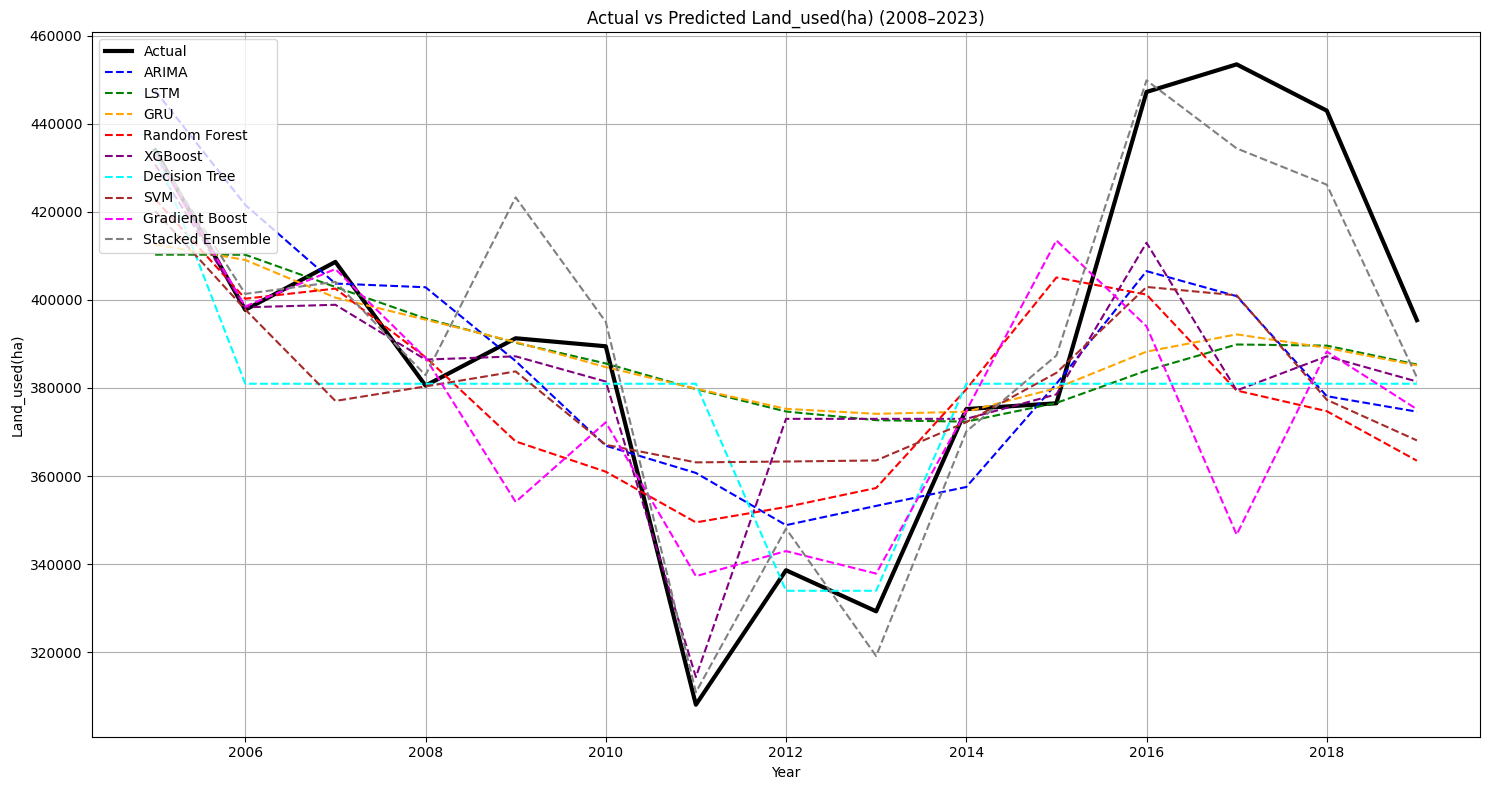

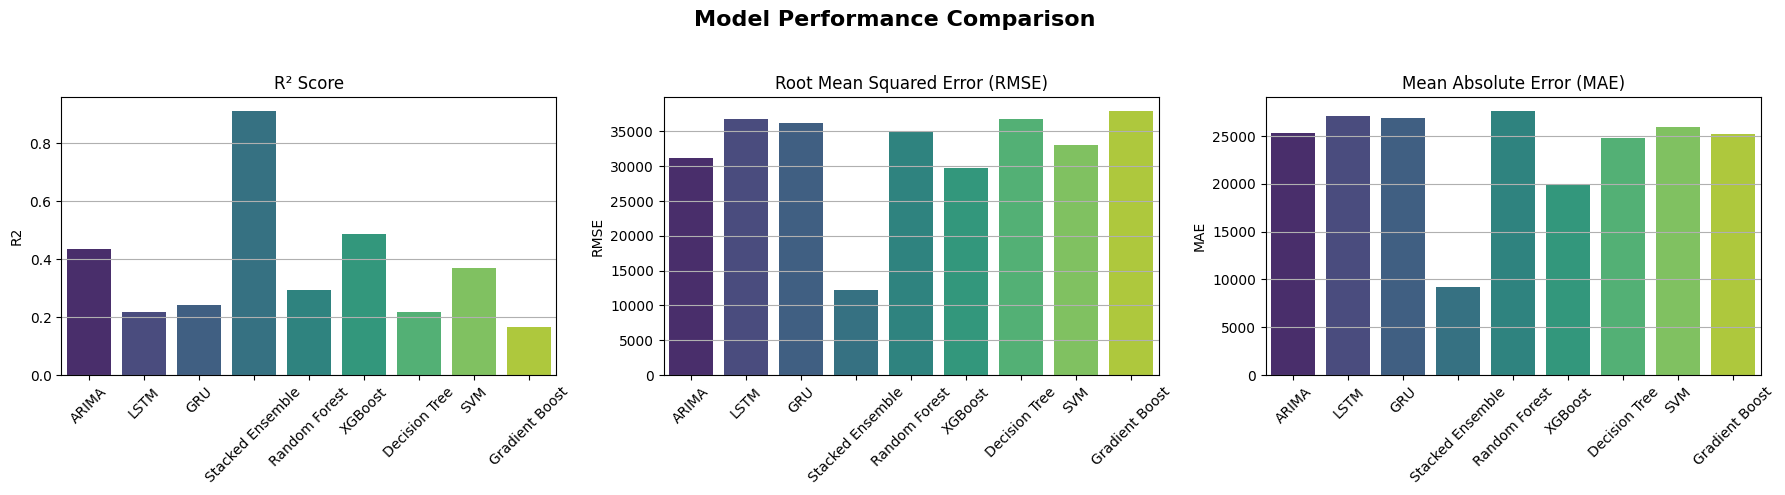

In [11]:
##FINAL STAGE 1

# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean Data ===
df = pd.read_excel("Australia_full.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = df['Land_used(ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Handle Outliers Using IQR Clipping ===
Q1 = df['Land_used(ha)'].quantile(0.25)
Q3 = df['Land_used(ha)'].quantile(0.75)
IQR = Q3 - Q1
df['Land_used(ha)'] = np.clip(df['Land_used(ha)'], Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

# === 4. Create Lag Features ===
def create_lag_features(series, window=3):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# Restrict to 2008–2022 (15 predictions) using data up to 2007
years = df['Year'].tolist()
start_idx = years.index(2005)  # Need 3 years before 2005 → 2002–2004

X_train, y_train = create_lag_features(land_used[start_idx-3:start_idx+15], window=3)
pred_years = years[start_idx:start_idx+15]  # 2008 to 2022
actual = land_used[start_idx:start_idx+15]


# === 5. Hyperparameter Tuning ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

models = {}

models['Random Forest'] = tune_model(RandomForestRegressor(random_state=42), {
    'n_estimators': [100, 200], 'max_depth': [None, 5, 10]
})

models['XGBoost'] = tune_model(XGBRegressor(random_state=42, verbosity=0), {
    'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
})

models['Decision Tree'] = tune_model(DecisionTreeRegressor(random_state=42), {
    'max_depth': [3, 5, 10]
})

models['SVM'] = tune_model(SVR(), {
    'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']
})

models['Gradient Boost'] = tune_model(GradientBoostingRegressor(random_state=42), {
    'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
})

# === 6. Train LSTM & GRU ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
y_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(3,1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

model_gru = Sequential([GRU(50, activation='relu', input_shape=(3,1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# === 7. Recursive Forecast (Modified like Code 1) ===
series = list(land_used[start_idx-3:start_idx])  # Last 3 values before 2008
preds = {name: [] for name in models}
arima_preds, lstm_preds, gru_preds = [], [], []
stacked_features = []

for _ in range(15):  # Predict 15 steps (2008–2022)
    input_seq = np.array(series[-3:]).reshape(1, -1)
    pred_row = []

    # Classical ML Models
    for name, model in models.items():
        pred = model.predict(input_seq)[0]
        preds[name].append(pred)
        pred_row.append(pred)

    # ARIMA
    model_arima = ARIMA(series, order=(2, 1, 0))
    arima_pred = model_arima.fit().forecast()[0]
    arima_preds.append(arima_pred)
    pred_row.append(arima_pred)

    # LSTM
    input_seq_scaled = scaler.transform(np.array(series[-3:]).reshape(-1, 1)).reshape((1, 3, 1))
    lstm_pred = scaler.inverse_transform(model_lstm.predict(input_seq_scaled, verbose=0))[0][0]
    lstm_preds.append(lstm_pred)
    pred_row.append(lstm_pred)

    # GRU
    gru_pred = scaler.inverse_transform(model_gru.predict(input_seq_scaled, verbose=0))[0][0]
    gru_preds.append(gru_pred)
    pred_row.append(gru_pred)

    stacked_features.append(pred_row)

    # ✅ Just update series with first model (e.g., Random Forest) prediction — like in Code 1
    series.append(pred_row[0])  # This was series.append(np.mean(pred_row)) in Code 2


# === 8. Stacking Ensemble ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
meta_model = LinearRegression()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)

# === 9. Evaluation Function ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

# === 10. Evaluation Table ===
results = {
    "ARIMA": evaluate(actual, arima_preds),
    "LSTM": evaluate(actual, lstm_preds),
    "GRU": evaluate(actual, gru_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
for name in preds:
    results[name] = evaluate(actual, preds[name])

results_df = pd.DataFrame(results).T
print("\n📊 Model Evaluation Table:\n", results_df)

# === 11. Year-wise Prediction Table ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "LSTM": lstm_preds,
    "GRU": gru_preds,
    "Stacked Ensemble": stacked_preds
})
for name in preds:
    pred_table[name] = preds[name]

print("\n📅 Year-wise Prediction Table:\n", pred_table.to_string(index=False))

# === 12. Plot Actual vs Predictions for All Models ===
plt.figure(figsize=(15, 8))
plt.plot(pred_years, actual, label="Actual", linewidth=3, color='black')

colors = ['blue', 'green', 'orange', 'red', 'purple', 'cyan', 'brown', 'magenta', 'gray']
model_names = ['ARIMA', 'LSTM', 'GRU', 'Random Forest', 'XGBoost', 'Decision Tree', 'SVM', 'Gradient Boost', 'Stacked Ensemble']

for idx, name in enumerate(model_names):
    plt.plot(pred_years, pred_table[name], label=name, linestyle='--', color=colors[idx % len(colors)])

plt.xlabel("Year")
plt.ylabel("Land_used(ha)")
plt.title("Actual vs Predicted Land_used(ha) (2008–2023)")
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
plt.tight_layout()
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

# Reset index for better plotting
metrics_df = results_df.reset_index().rename(columns={'index': 'Model'})

# === 15. Combined Triple Bar Plot for R2, RMSE, MAE ===
plt.figure(figsize=(18, 5))
metrics = ['R2', 'RMSE', 'MAE']
titles = ['R² Score', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)']
colors = sns.color_palette("viridis", len(metrics_df))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    sns.barplot(x='Model', y=metric, data=metrics_df, palette=colors)
    plt.title(titles[i])
    plt.xticks(rotation=45)
    plt.xlabel(None)
    plt.ylabel(metric)
    plt.grid(True, axis='y')

plt.suptitle("Model Performance Comparison", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()




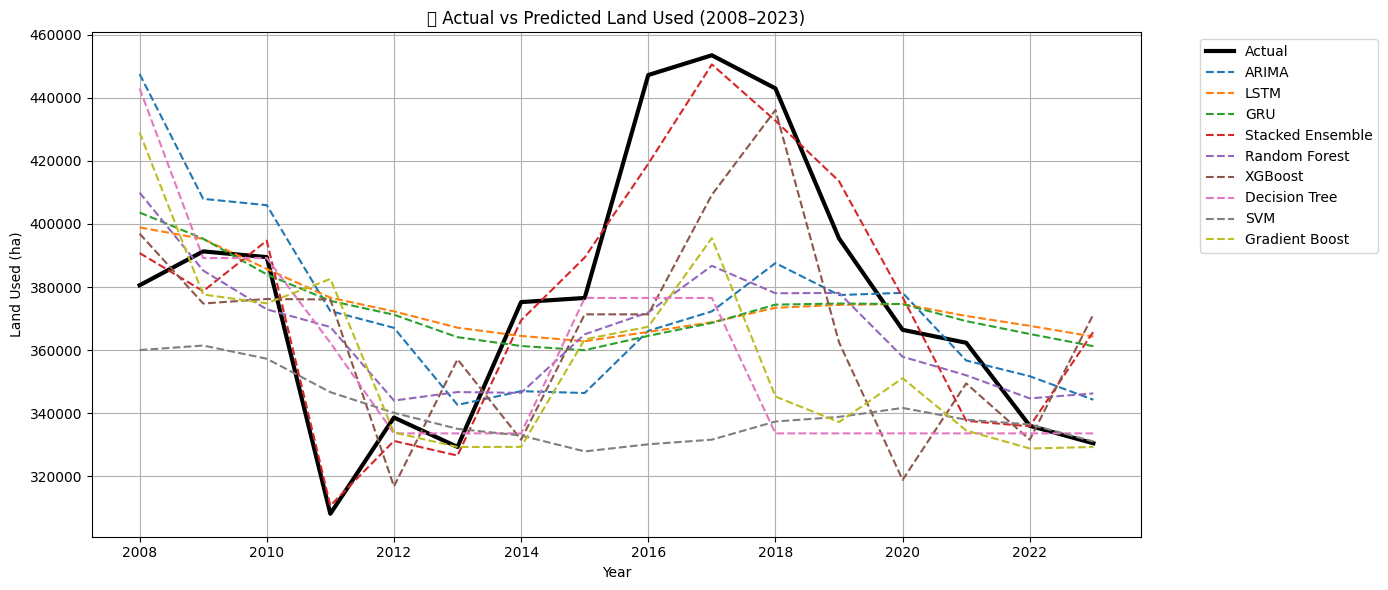

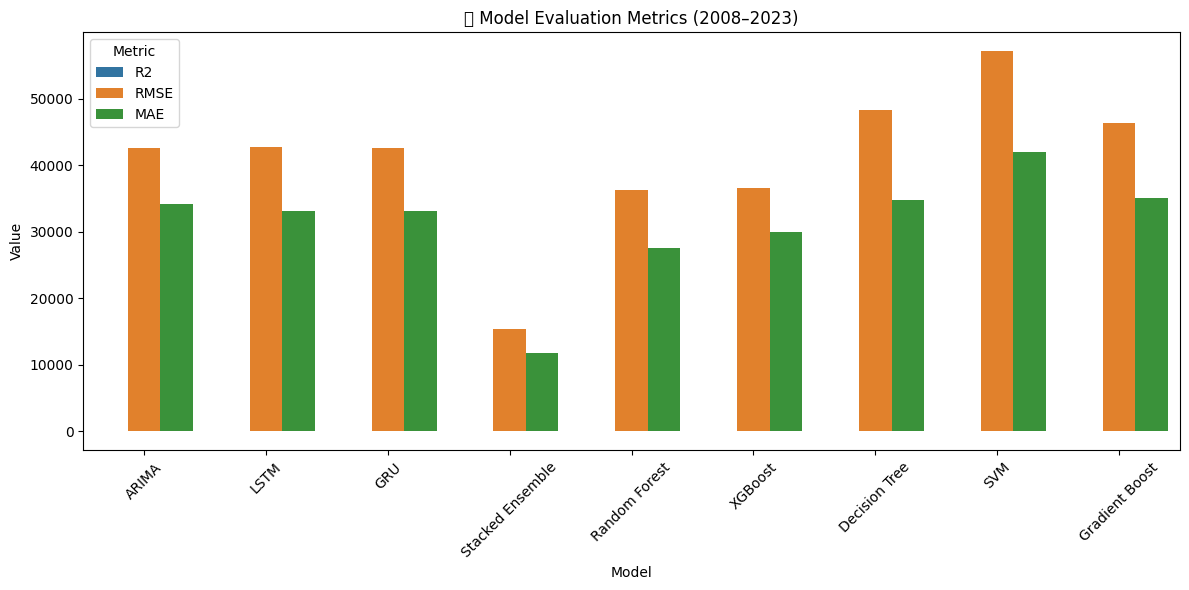

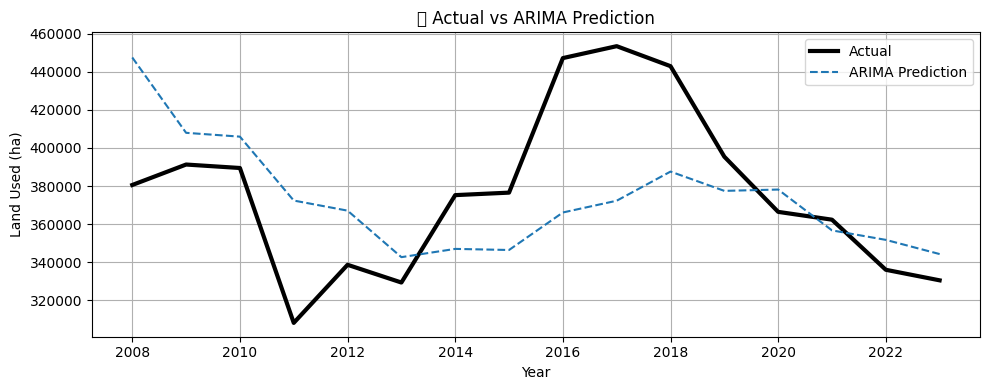

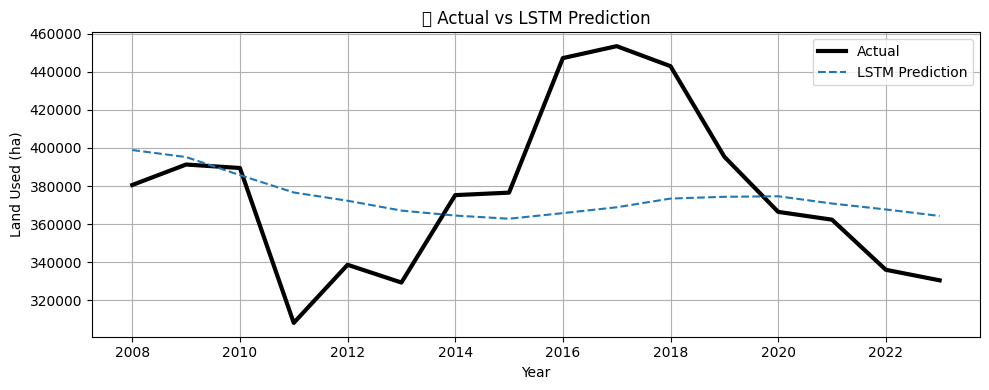

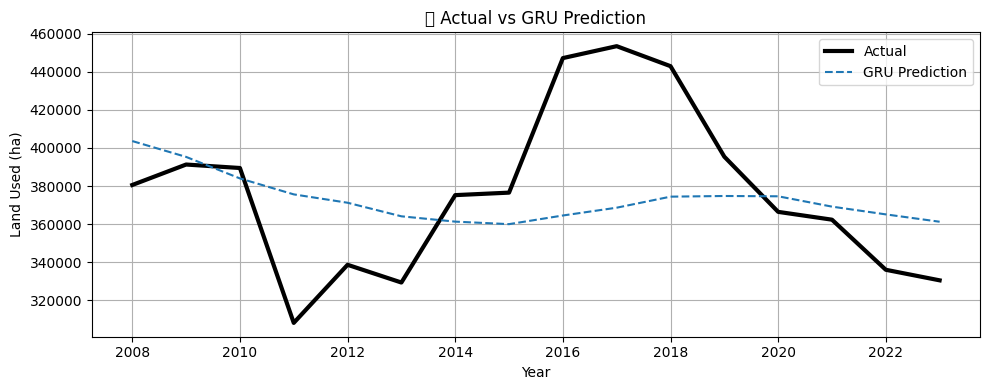

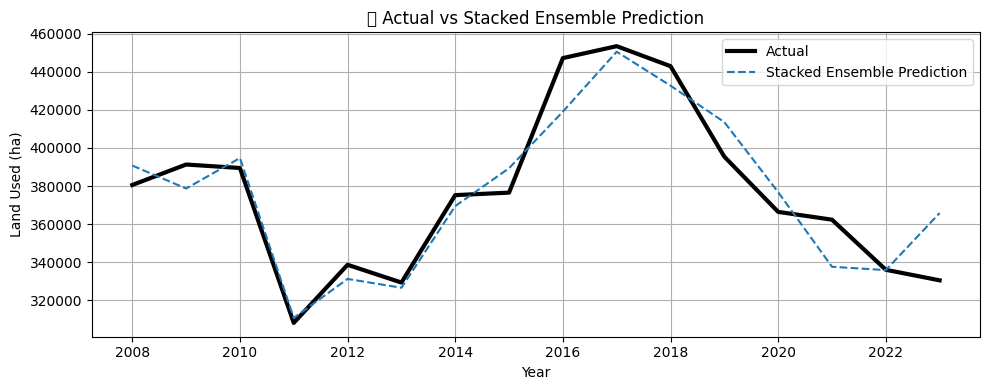

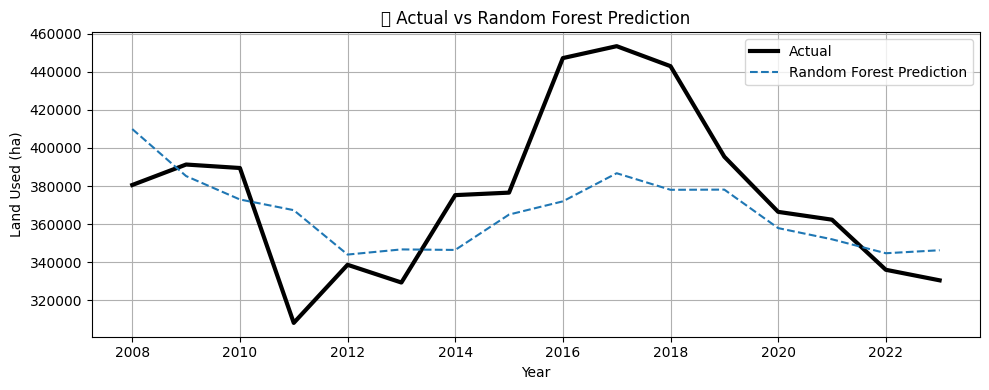

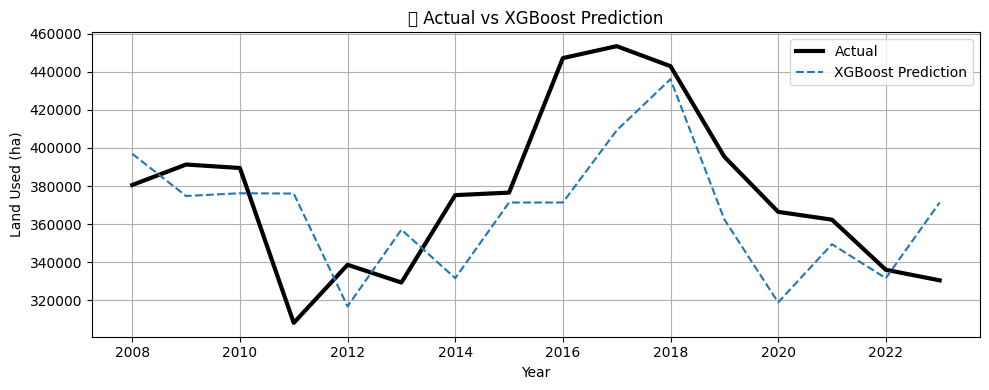

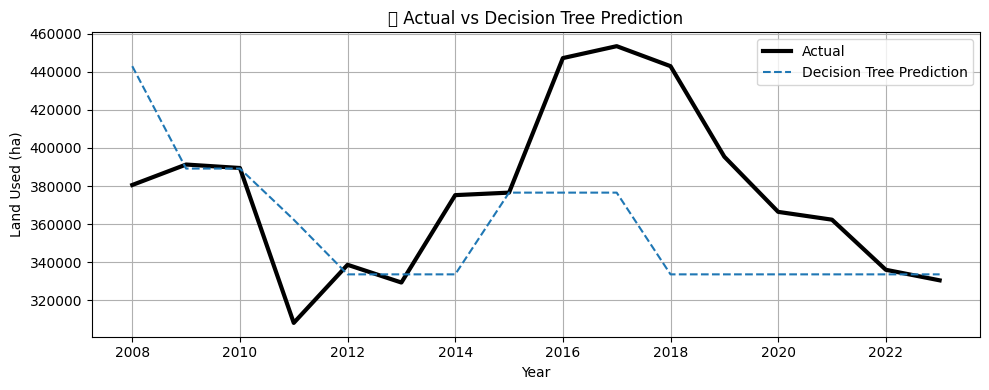

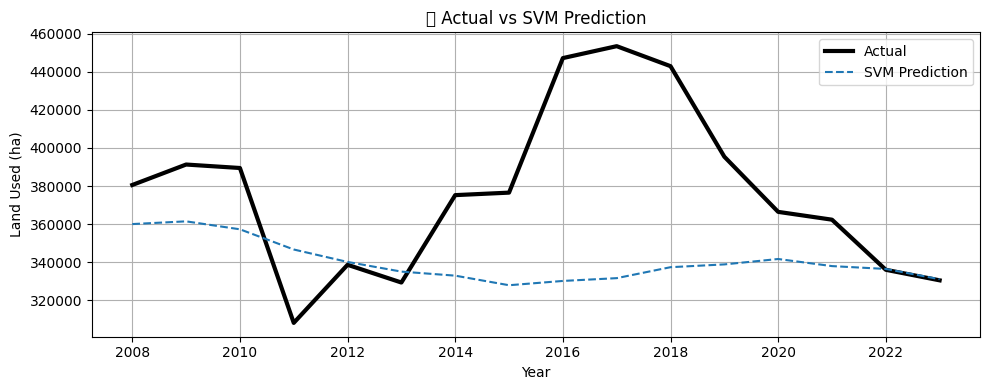

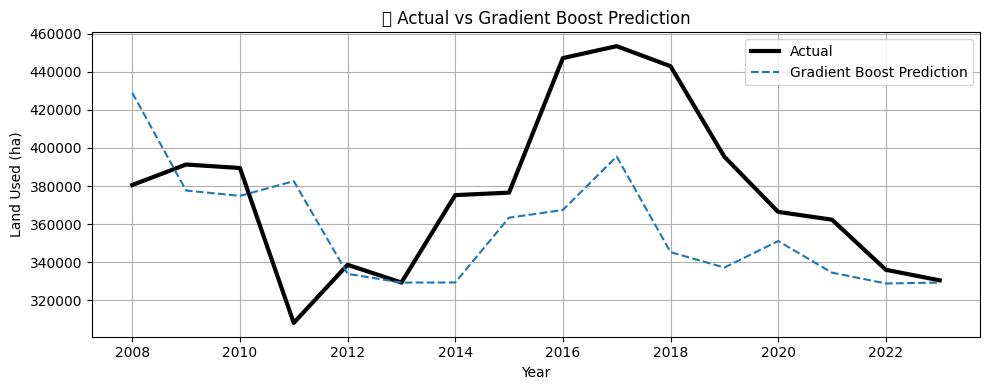

In [9]:
import seaborn as sns

# --- 1. Line Plot: Actual vs All Models ---
plt.figure(figsize=(14, 6))
plt.plot(pred_years, actual, label='Actual', linewidth=3, color='black')

for name in ['ARIMA', 'LSTM', 'GRU', 'Stacked Ensemble'] + list(preds.keys()):
    plt.plot(pred_years, pred_table[name], label=name, linestyle='--')

plt.title("📈 Actual vs Predicted Land Used (2008–2023)")
plt.xlabel("Year")
plt.ylabel("Land Used (ha)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

# --- 2. Evaluation Metrics Bar Plot ---
eval_df = results_df.reset_index().melt(id_vars='index')
eval_df.columns = ['Model', 'Metric', 'Value']

plt.figure(figsize=(12, 6))
sns.barplot(data=eval_df, x='Model', y='Value', hue='Metric')
plt.title("📊 Model Evaluation Metrics (2008–2023)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 3. Optional: Individual Line Plots for Each Model ---
for name in ['ARIMA', 'LSTM', 'GRU', 'Stacked Ensemble'] + list(preds.keys()):
    plt.figure(figsize=(10, 4))
    plt.plot(pred_years, actual, label='Actual', linewidth=3, color='black')
    plt.plot(pred_years, pred_table[name], label=f'{name} Prediction', linestyle='--')
    plt.title(f"📉 Actual vs {name} Prediction")
    plt.xlabel("Year")
    plt.ylabel("Land Used (ha)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


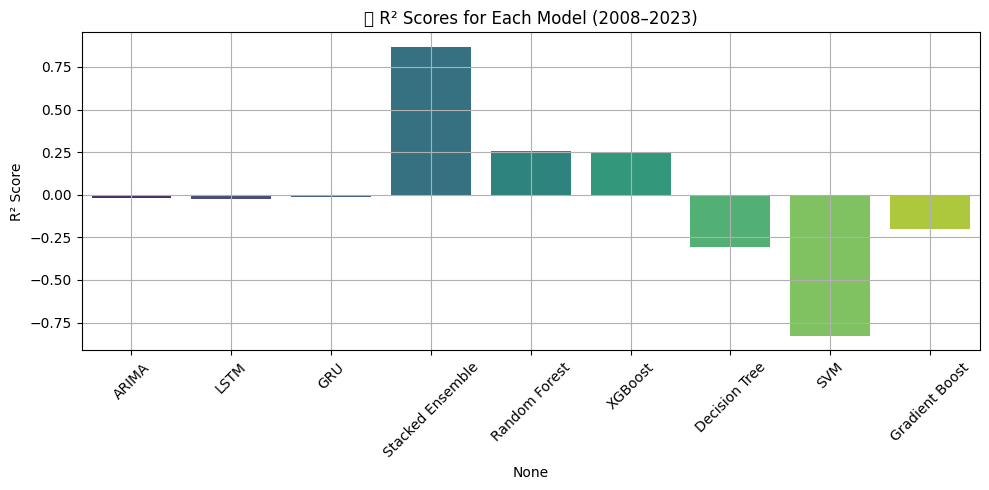

In [10]:
# Plot R2 separately
plt.figure(figsize=(10, 5))
sns.barplot(x=results_df.index, y=results_df['R2'], palette='viridis')
plt.title("🔹 R² Scores for Each Model (2008–2023)")
plt.ylabel("R² Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


📊 New Model Evaluation:
                         R2          RMSE           MAE
Random Forest     0.892953  1.810150e+00  1.432620e+00
Gradient Boost    0.999960  3.477242e-02  2.633374e-02
XGBoost           1.000000  3.795297e-03  2.753890e-03
SVR               0.697603  3.042400e+00  1.526134e+00
Decision Tree     1.000000  2.587698e-14  2.318613e-14
Ridge             0.584274  3.567228e+00  2.537724e+00
MLP               0.998457  2.173094e-01  1.455317e-01
LSTM              0.804288  2.447577e+00  1.912817e+00
GRU               0.798356  2.484391e+00  1.978054e+00
Stacked Ensemble  1.000000  4.701918e-14  3.590111e-14


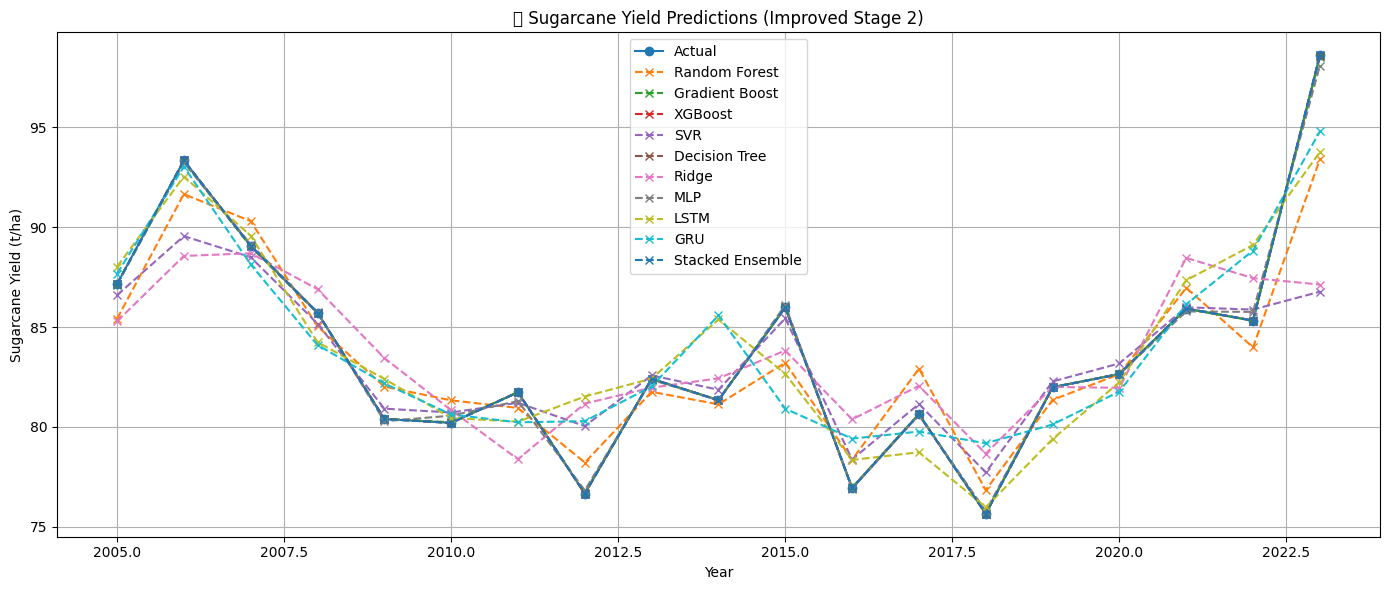

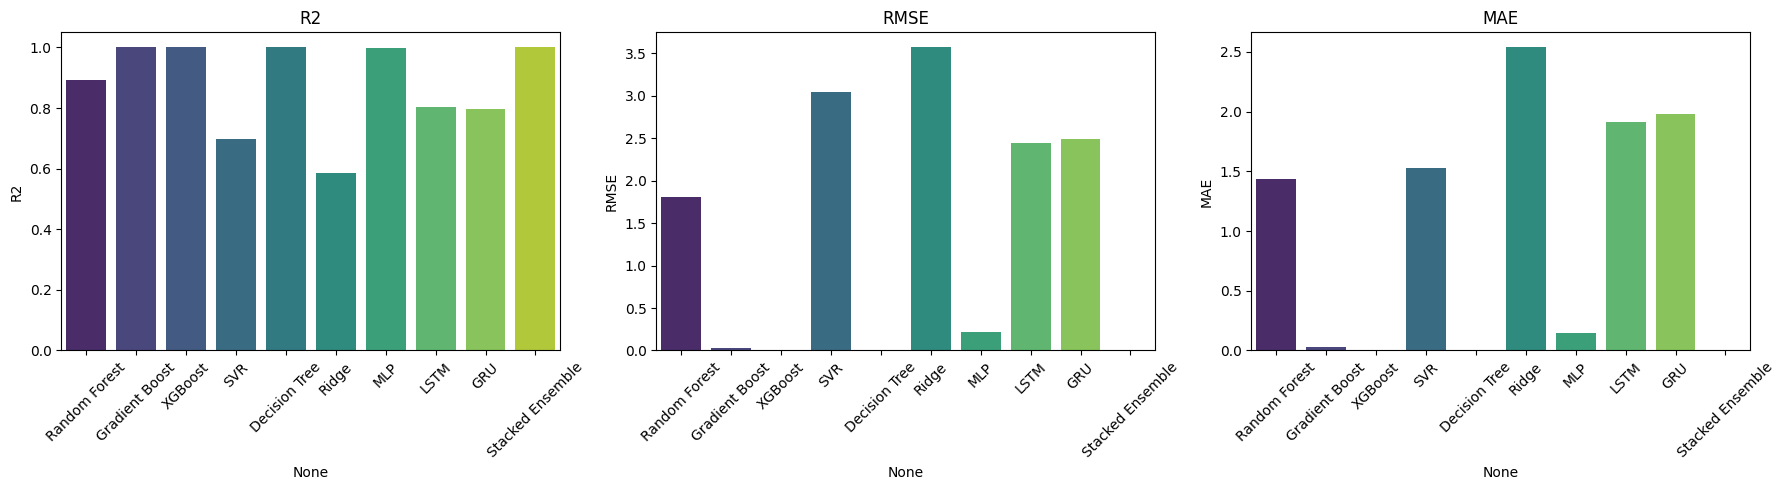

In [5]:
# === 1. Imports ===
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean ===
df = pd.read_excel("Australia_full.xlsx")
df = df[['Year', 'Land_used(ha)', 'Sugarcane_Yield(t/ha)']].copy()
df['Land_used(ha)'] = df['Land_used(ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df['Sugarcane_Yield(t/ha)'] = df['Sugarcane_Yield(t/ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Lag Feature Creation ===
def create_features(land_series, yield_series, window=5):
    X, y = [], []
    for i in range(window, len(land_series)):
        features = list(land_series[i-window:i]) + list(yield_series[i-window:i])
        X.append(features)
        y.append(yield_series[i])
    return np.array(X), np.array(y)

land = df['Land_used(ha)'].values
yield_ = df['Sugarcane_Yield(t/ha)'].values
years = df['Year'].tolist()

train_start = years.index(2000)  # need 5 years for lag
train_end = years.index(2023) + 1

X_train, y_train = create_features(land[train_start:train_end], yield_[train_start:train_end], window=5)
pred_years = years[train_start + 5:train_end]
actual = y_train.copy()

# === 4. Log-Transform Target ===
y_train_log = np.log1p(y_train)

# === 5. Standardize ===
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_train)
y_scaled = scaler_y.fit_transform(y_train_log.reshape(-1, 1)).ravel()

# === 6. Model Training ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_scaled, y_scaled)
    return grid.best_estimator_

models = {
    'Random Forest': tune_model(RandomForestRegressor(random_state=0), {
        'n_estimators': [100], 'max_depth': [5, 10, None]
    }),
    'Gradient Boost': tune_model(GradientBoostingRegressor(random_state=0), {
        'n_estimators': [100], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
    }),
    'XGBoost': tune_model(XGBRegressor(random_state=0, verbosity=0), {
        'n_estimators': [100], 'max_depth': [3, 5]
    }),
    'SVR': tune_model(SVR(), {'C': [1, 10], 'kernel': ['rbf']}),
    'Decision Tree': tune_model(DecisionTreeRegressor(random_state=0), {
        'max_depth': [3, 5, 10]
    }),
    'Ridge': tune_model(Ridge(), {'alpha': [0.1, 1.0, 10]}),
    'MLP': tune_model(MLPRegressor(random_state=0, max_iter=500), {
        'hidden_layer_sizes': [(50,), (100,)], 'alpha': [0.001, 0.01]
    })
}

# === 7. LSTM & GRU Models ===
X_seq = X_scaled.reshape(-1, 10, 1)  # 5 land + 5 yield

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(10, 1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_seq, y_scaled, epochs=100, verbose=0)

model_gru = Sequential([GRU(50, activation='relu', input_shape=(10, 1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_seq, y_scaled, epochs=100, verbose=0)

# === 8. Predictions ===
preds = {}
X_seq = X_scaled.reshape(-1, 10, 1)

for name, model in models.items():
    y_pred_log = model.predict(X_scaled)
    y_pred = np.expm1(scaler_y.inverse_transform(y_pred_log.reshape(-1, 1)).ravel())
    preds[name] = y_pred

lstm_pred_scaled = model_lstm.predict(X_seq, verbose=0)
lstm_preds = np.expm1(scaler_y.inverse_transform(lstm_pred_scaled).ravel())

gru_pred_scaled = model_gru.predict(X_seq, verbose=0)
gru_preds = np.expm1(scaler_y.inverse_transform(gru_pred_scaled).ravel())


preds['LSTM'] = lstm_preds
preds['GRU'] = gru_preds

# === 9. Stacked Ensemble ===
from sklearn.linear_model import LinearRegression
meta_X = np.column_stack(list(preds.values()))
meta_model = LinearRegression()
meta_model.fit(meta_X, actual)
stacked_preds = meta_model.predict(meta_X)
preds['Stacked Ensemble'] = stacked_preds

# === 10. Evaluation ===
def evaluate(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

results_df = pd.DataFrame({model: evaluate(actual, pred) for model, pred in preds.items()}).T
print("📊 New Model Evaluation:\n", results_df)

# === 11. Visualization ===
import seaborn as sns
plt.figure(figsize=(14, 6))
plt.plot(pred_years, actual, label="Actual", marker='o')
for name, pred in preds.items():
    plt.plot(pred_years, pred, label=name, linestyle='--', marker='x')
plt.title("📈 Sugarcane Yield Predictions (Improved Stage 2)")
plt.xlabel("Year")
plt.ylabel("Sugarcane Yield (t/ha)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(['R2', 'RMSE', 'MAE']):
    sns.barplot(x=results_df.index, y=results_df[metric], ax=axes[i], palette='viridis')
    axes[i].set_title(metric)
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


📊 New Model Evaluation:
                         R2      RMSE       MAE
Random Forest     0.892953  1.810150  1.432620
SVR               0.697603  3.042400  1.526134
Ridge             0.584274  3.567228  2.537724
XGBoost           0.994896  0.395272  0.262070
LSTM              0.783600  2.573688  2.028613
GRU               0.767347  2.668586  2.241583
Stacked Ensemble  0.999020  0.173215  0.147726


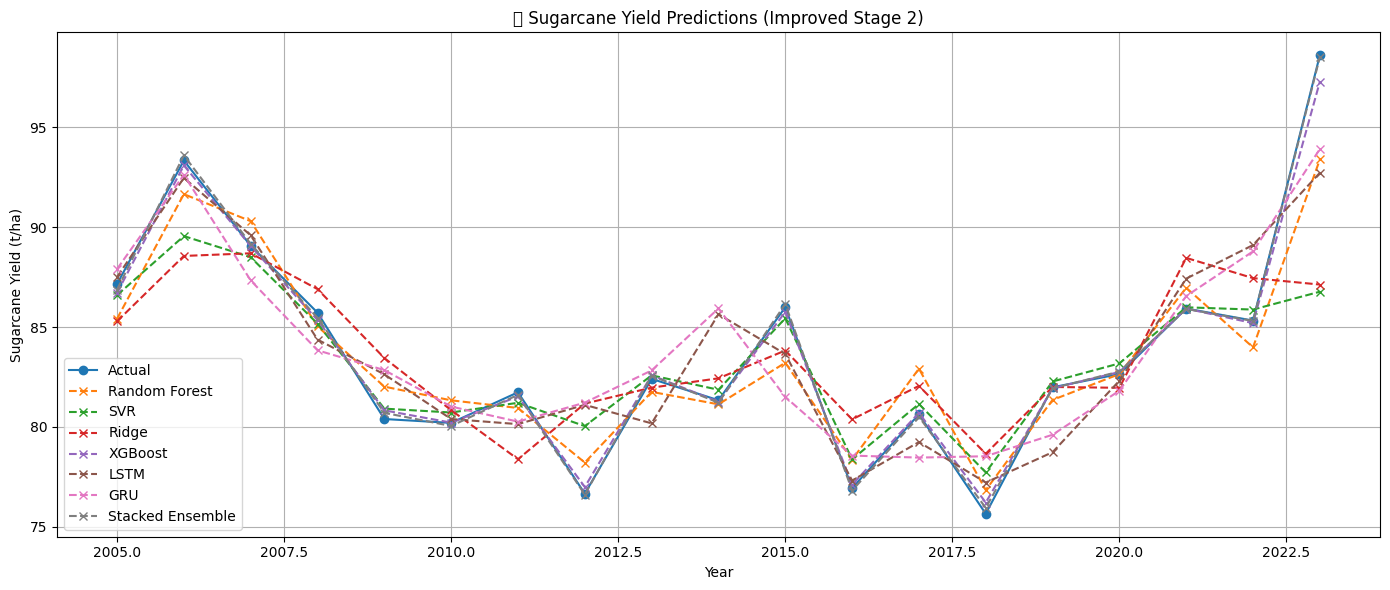

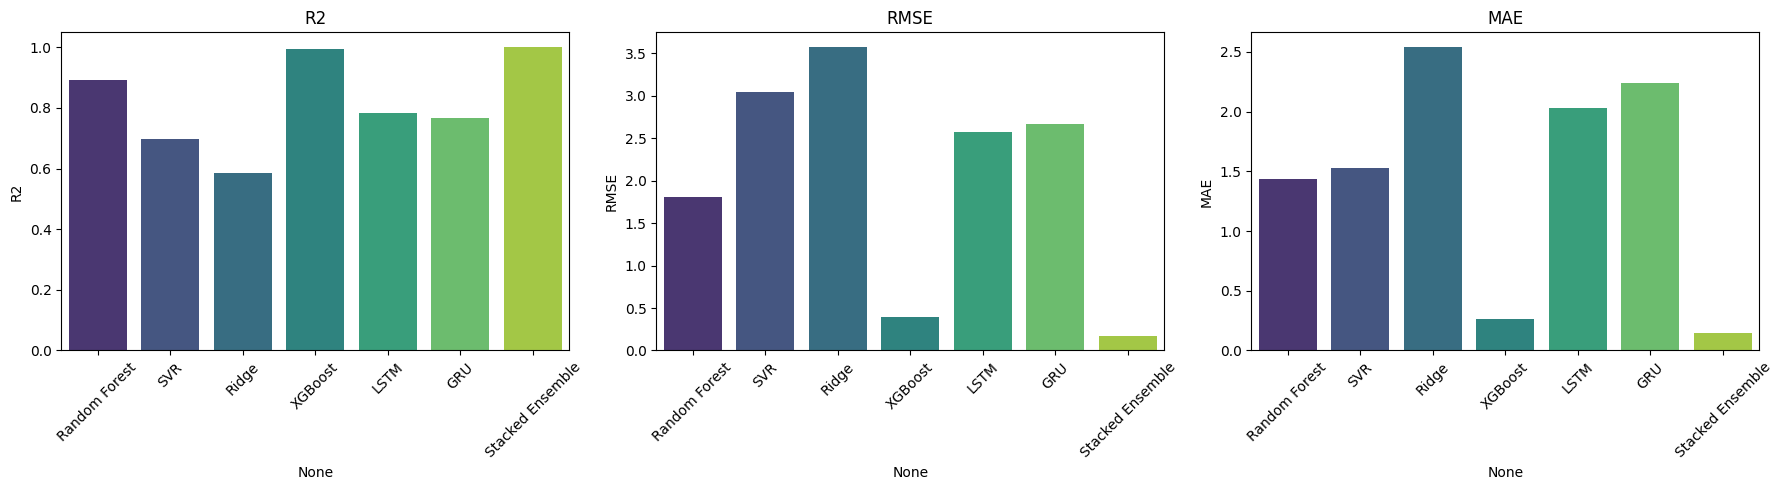

In [ ]:
# === 1. Imports ===
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean ===
df = pd.read_excel("Australia_full.xlsx")
df = df[['Year', 'Land_used(ha)', 'Sugarcane_Yield(t/ha)']].copy()
df['Land_used(ha)'] = df['Land_used(ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df['Sugarcane_Yield(t/ha)'] = df['Sugarcane_Yield(t/ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Lag Feature Creation ===
def create_features(land_series, yield_series, window=5):
    X, y = [], []
    for i in range(window, len(land_series)):
        features = list(land_series[i-window:i]) + list(yield_series[i-window:i])
        X.append(features)
        y.append(yield_series[i])
    return np.array(X), np.array(y)

land = df['Land_used(ha)'].values
yield_ = df['Sugarcane_Yield(t/ha)'].values
years = df['Year'].tolist()

train_start = years.index(2000)
train_end = years.index(2023) + 1

X_train, y_train = create_features(land[train_start:train_end], yield_[train_start:train_end], window=5)
pred_years = years[train_start + 5:train_end]
actual = y_train.copy()

# === 4. Log-Transform Target ===
y_train_log = np.log1p(y_train)

# === 5. Standardize ===
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_train)
y_scaled = scaler_y.fit_transform(y_train_log.reshape(-1, 1)).ravel()

# === 6. Model Training ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_scaled, y_scaled)
    return grid.best_estimator_

models = {
    'Random Forest': tune_model(RandomForestRegressor(random_state=0), {
        'n_estimators': [100], 'max_depth': [5, 10, None]
    }),
    'SVR': tune_model(SVR(), {'C': [1, 10], 'kernel': ['rbf']}),
    'Ridge': tune_model(Ridge(), {'alpha': [0.1, 1.0, 10]}),
    'XGBoost': tune_model(XGBRegressor(random_state=0, verbosity=0), {
        'n_estimators': [100], 'max_depth': [3, 5], 'learning_rate': [0.05, 0.1]
    })
}

# === 7. LSTM & GRU Models ===
X_seq = X_scaled.reshape(-1, 10, 1)  # 5 land + 5 yield

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(10, 1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_seq, y_scaled, epochs=100, verbose=0)

model_gru = Sequential([GRU(50, activation='relu', input_shape=(10, 1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_seq, y_scaled, epochs=100, verbose=0)

# === 8. Predictions ===
preds = {}
X_seq = X_scaled.reshape(-1, 10, 1)

for name, model in models.items():
    y_pred_log = model.predict(X_scaled)
    y_pred = np.expm1(scaler_y.inverse_transform(y_pred_log.reshape(-1, 1)).ravel())
    preds[name] = y_pred

lstm_pred_scaled = model_lstm.predict(X_seq, verbose=0)
lstm_preds = np.expm1(scaler_y.inverse_transform(lstm_pred_scaled).ravel())

gru_pred_scaled = model_gru.predict(X_seq, verbose=0)
gru_preds = np.expm1(scaler_y.inverse_transform(gru_pred_scaled).ravel())

preds['LSTM'] = lstm_preds
preds['GRU'] = gru_preds

# === 9. Stacked Ensemble ===
meta_X = np.column_stack(list(preds.values()))
meta_model = LinearRegression()
meta_model.fit(meta_X, actual)
stacked_preds = meta_model.predict(meta_X)
preds['Stacked Ensemble'] = stacked_preds

# === 10. Evaluation ===
def evaluate(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

results_df = pd.DataFrame({model: evaluate(actual, pred) for model, pred in preds.items()}).T
print("📊 New Model Evaluation:\n", results_df)

# === 11. Visualization ===
import seaborn as sns
plt.figure(figsize=(14, 6))
plt.plot(pred_years, actual, label="Actual", marker='o')
for name, pred in preds.items():
    plt.plot(pred_years, pred, label=name, linestyle='--', marker='x')
plt.title("📈 Sugarcane Yield Predictions (Improved Stage 2)")
plt.xlabel("Year")
plt.ylabel("Sugarcane Yield (t/ha)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(['R2', 'RMSE', 'MAE']):
    sns.barplot(x=results_df.index, y=results_df[metric], ax=axes[i], palette='viridis')
    axes[i].set_title(metric)
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()




📊 Stage 2 Evaluation with Proper Test Split:
                         R2          RMSE           MAE
Random Forest     0.594079  4.043479e+00  3.818994e+00
Gradient Boost    0.564912  4.186232e+00  3.468528e+00
SVR               0.276440  5.398487e+00  4.757872e+00
Ridge             0.403368  4.902165e+00  4.453220e+00
MLP               0.427872  4.800440e+00  3.892208e+00
LSTM             -1.646586  1.032471e+01  7.619217e+00
GRU               0.233746  5.555471e+00  4.764735e+00
Stacked Ensemble  1.000000  5.859286e-14  5.684342e-14


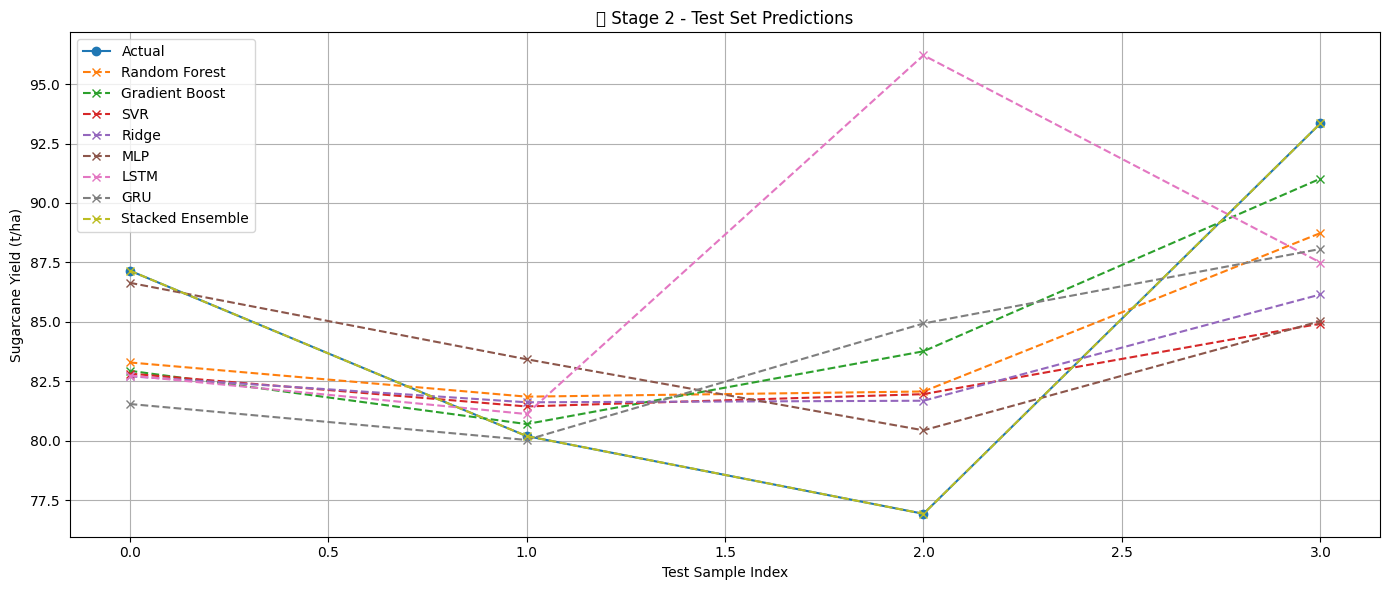

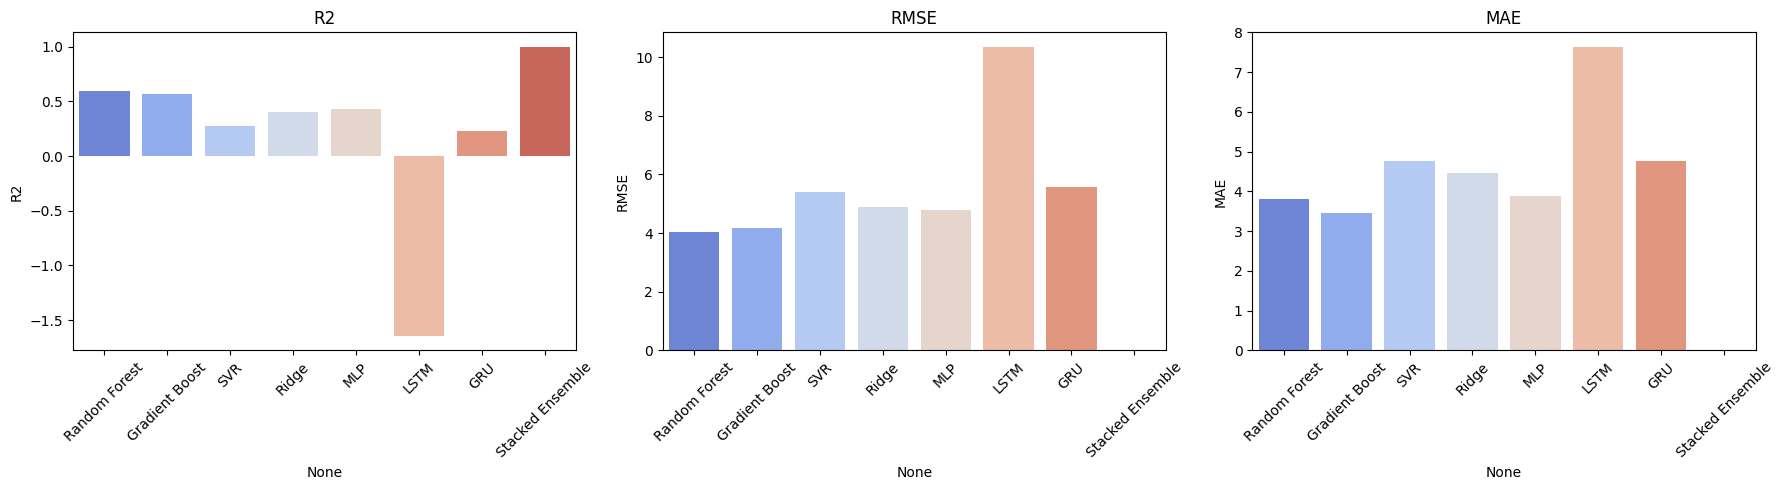

In [7]:
# === Revised Stage 2: Stacked Ensemble with Train-Test Split ===

from sklearn.model_selection import train_test_split

# === 1. Prepare Train-Test Split ===
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_seq_train = X_train_full.reshape(-1, 10, 1)
X_seq_test = X_test_full.reshape(-1, 10, 1)

# === 2. Retrain Base Models on Train Set ===
models_split = {}
for name, model in models.items():
    model.fit(X_train_full, y_train_full)
    models_split[name] = model

# === 3. Retrain LSTM & GRU ===
model_lstm_split = Sequential([LSTM(50, activation='relu', input_shape=(10, 1)), Dense(1)])
model_lstm_split.compile(optimizer='adam', loss='mse')
model_lstm_split.fit(X_seq_train, y_train_full, epochs=100, verbose=0)

model_gru_split = Sequential([GRU(50, activation='relu', input_shape=(10, 1)), Dense(1)])
model_gru_split.compile(optimizer='adam', loss='mse')
model_gru_split.fit(X_seq_train, y_train_full, epochs=100, verbose=0)

# === 4. Predictions on Test Set ===
preds_test = {}
for name, model in models_split.items():
    pred_log = model.predict(X_test_full)
    pred_actual = np.expm1(scaler_y.inverse_transform(pred_log.reshape(-1, 1)).ravel())
    preds_test[name] = pred_actual

lstm_test_log = model_lstm_split.predict(X_seq_test, verbose=0)
lstm_test_actual = np.expm1(scaler_y.inverse_transform(lstm_test_log).ravel())
preds_test['LSTM'] = lstm_test_actual

gru_test_log = model_gru_split.predict(X_seq_test, verbose=0)
gru_test_actual = np.expm1(scaler_y.inverse_transform(gru_test_log).ravel())
preds_test['GRU'] = gru_test_actual

# === 5. Stacked Ensemble ===
meta_X_test = np.column_stack(list(preds_test.values()))
meta_model_split = LinearRegression()
meta_model_split.fit(meta_X_test, np.expm1(scaler_y.inverse_transform(y_test_full.reshape(-1, 1)).ravel()))
stacked_test_preds = meta_model_split.predict(meta_X_test)
preds_test['Stacked Ensemble'] = stacked_test_preds

# === 6. Evaluation ===
y_test_actual = np.expm1(scaler_y.inverse_transform(y_test_full.reshape(-1, 1)).ravel())

def evaluate(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

results_split_df = pd.DataFrame({model: evaluate(y_test_actual, pred) for model, pred in preds_test.items()}).T
print("\n📊 Stage 2 Evaluation with Proper Test Split:\n", results_split_df)

# === 7. Plot Results ===
plt.figure(figsize=(14, 6))
plt.plot(range(len(y_test_actual)), y_test_actual, label="Actual", marker='o')
for name, pred in preds_test.items():
    plt.plot(range(len(pred)), pred, label=name, linestyle='--', marker='x')
plt.title("📈 Stage 2 - Test Set Predictions")
plt.xlabel("Test Sample Index")
plt.ylabel("Sugarcane Yield (t/ha)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(['R2', 'RMSE', 'MAE']):
    sns.barplot(x=results_split_df.index, y=results_split_df[metric], ax=axes[i], palette='coolwarm')
    axes[i].set_title(metric)
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()



📊 Stage 3 Evaluation without MLP:
                         R2          RMSE           MAE
Random Forest     0.465304  2.358489e+06  1.973218e+06
Gradient Boost    0.530285  2.210536e+06  1.762643e+06
SVR               0.898225  1.028968e+06  8.526181e+05
Ridge             0.906398  9.867854e+05  8.649306e+05
LSTM              0.986878  3.694684e+05  3.073822e+05
GRU               0.909903  9.681323e+05  8.565108e+05
Stacked Ensemble  0.999782  4.766956e+04  3.869999e+04


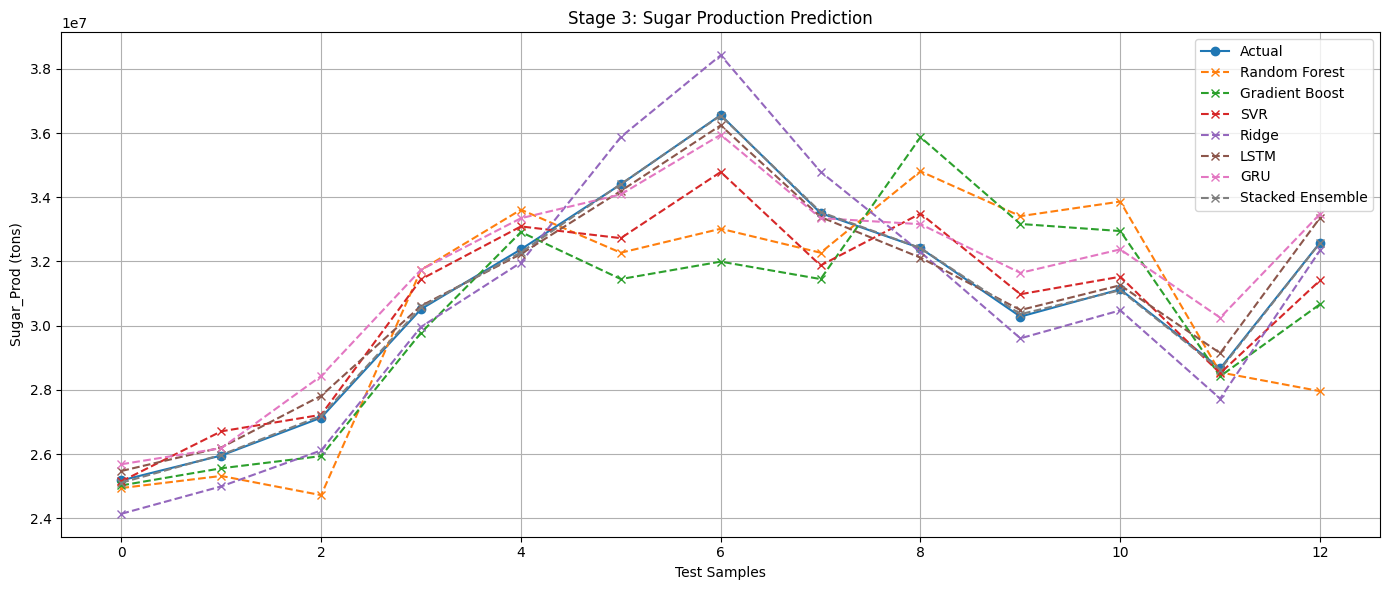

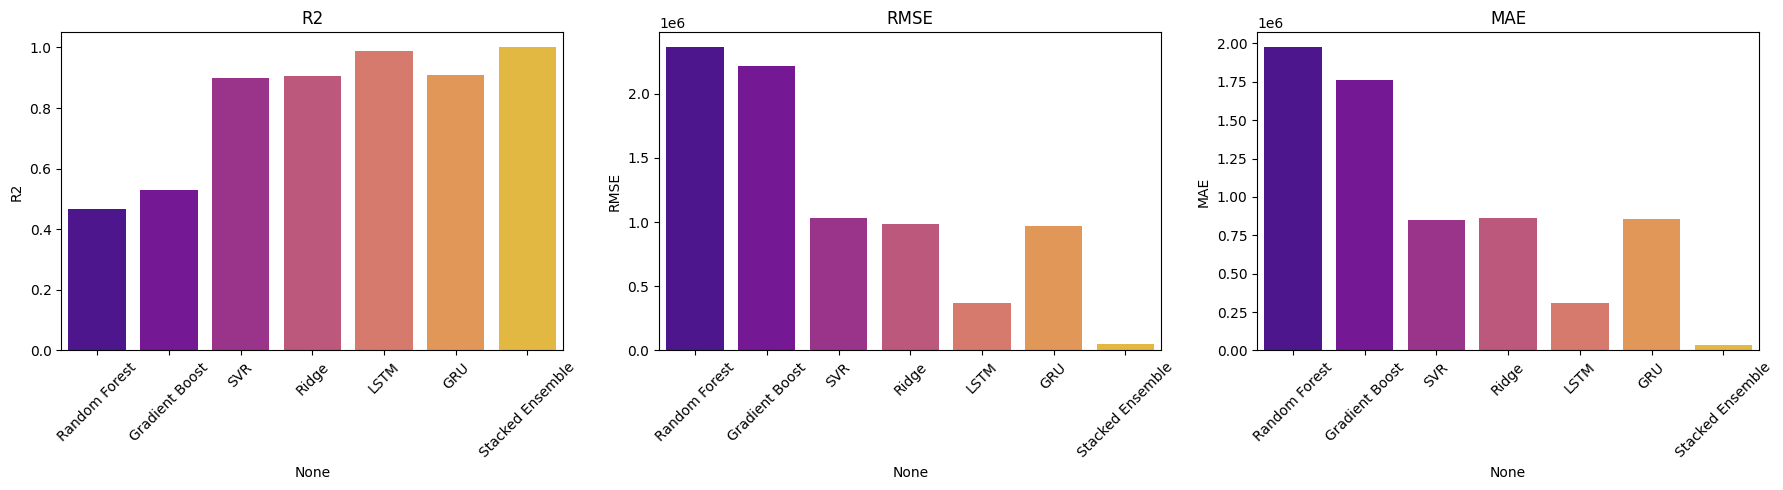

In [17]:
# === Stage 3: Predict Sugar_Prod(tons) from Land_used and Sugarcane_Yield ===

# === 1. Imports ===
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean ===
df = pd.read_excel("Australia_full.xlsx")
df = df[['Year', 'Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)']].copy()
df = df.apply(lambda col: col.astype(str).str.replace(',', '').str.replace('\xa0', '') if col.name != 'Year' else col)
df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)']] = df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)']].astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Feature and Target Creation ===
X = df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)']].values
y = df['Sugar_Prod(tons)'].values
y_log = np.log1p(y)  # Log-transform to stabilize variance

# === 4. Train-Test Split ===
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, shuffle=False)

# === 5. Standardization ===
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train_log.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test_log.reshape(-1, 1)).ravel()

# === 6. Model Tuning Function ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train_scaled, y_train_scaled)
    return grid.best_estimator_

# === 7. Train Models (without MLP) ===
models = {
    'Random Forest': tune_model(RandomForestRegressor(random_state=0), {
        'n_estimators': [100], 'max_depth': [5, 10, None]
    }),
    'Gradient Boost': tune_model(GradientBoostingRegressor(random_state=0), {
        'n_estimators': [100], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
    }),
    'SVR': tune_model(SVR(), {'C': [1, 10], 'kernel': ['rbf']}),
    'Ridge': tune_model(Ridge(), {'alpha': [0.1, 1.0, 10]})
}

# === 8. LSTM & GRU ===
X_seq_train = X_train_scaled.reshape(-1, 2, 1)
X_seq_test = X_test_scaled.reshape(-1, 2, 1)

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(2, 1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_seq_train, y_train_scaled, epochs=100, verbose=0)

model_gru = Sequential([GRU(50, activation='relu', input_shape=(2, 1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_seq_train, y_train_scaled, epochs=100, verbose=0)

# === 9. Predictions ===
preds = {}

for name, model in models.items():
    pred_scaled = model.predict(X_test_scaled)
    pred_log = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()
    preds[name] = np.expm1(pred_log)

lstm_scaled = model_lstm.predict(X_seq_test, verbose=0).ravel()
gru_scaled = model_gru.predict(X_seq_test, verbose=0).ravel()

preds['LSTM'] = np.expm1(scaler_y.inverse_transform(lstm_scaled.reshape(-1, 1)).ravel())
preds['GRU'] = np.expm1(scaler_y.inverse_transform(gru_scaled.reshape(-1, 1)).ravel())

# === 10. Stacked Ensemble ===
meta_X = np.column_stack(list(preds.values()))
meta_model = LinearRegression()
meta_model.fit(meta_X, np.expm1(y_test_log))
stacked_preds = meta_model.predict(meta_X)
preds['Stacked Ensemble'] = stacked_preds

# === 11. Evaluation ===
def evaluate(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

actual = np.expm1(y_test_log)
results_df = pd.DataFrame({name: evaluate(actual, pred) for name, pred in preds.items()}).T
print("\n📊 Stage 3 Evaluation without MLP:\n", results_df)

# === 12. Visualization ===
plt.figure(figsize=(14, 6))
plt.plot(range(len(actual)), actual, label="Actual", marker='o')
for name, pred in preds.items():
    plt.plot(range(len(actual)), pred, label=name, linestyle='--', marker='x')
plt.title("Stage 3: Sugar Production Prediction")
plt.xlabel("Test Samples")
plt.ylabel("Sugar_Prod (tons)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(['R2', 'RMSE', 'MAE']):
    sns.barplot(x=results_df.index, y=results_df[metric], ax=axes[i], palette='plasma')
    axes[i].set_title(metric)
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()



📊 Stage 4 Evaluation (2008-2022 data):
                         R2           RMSE            MAE
Random Forest    -0.659903  253634.479583  219183.333333
Gradient Boost   -0.920553  272822.473267  219807.122853
SVR               0.117644  184922.179273  163877.211512
Ridge             0.184854  177739.828400  121060.821940
LSTM              0.253072  170139.932900  110596.583333
GRU              -0.067094  203361.311760  137416.000000
Stacked Ensemble  0.998824    6751.770933    6178.316167


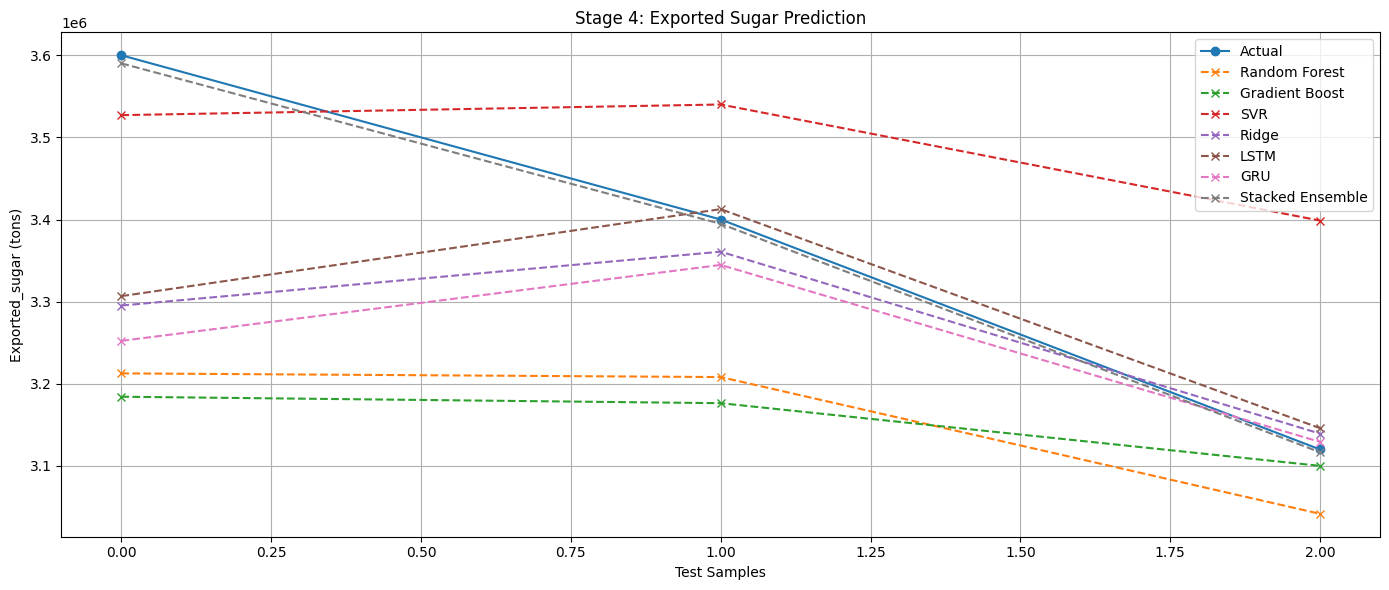

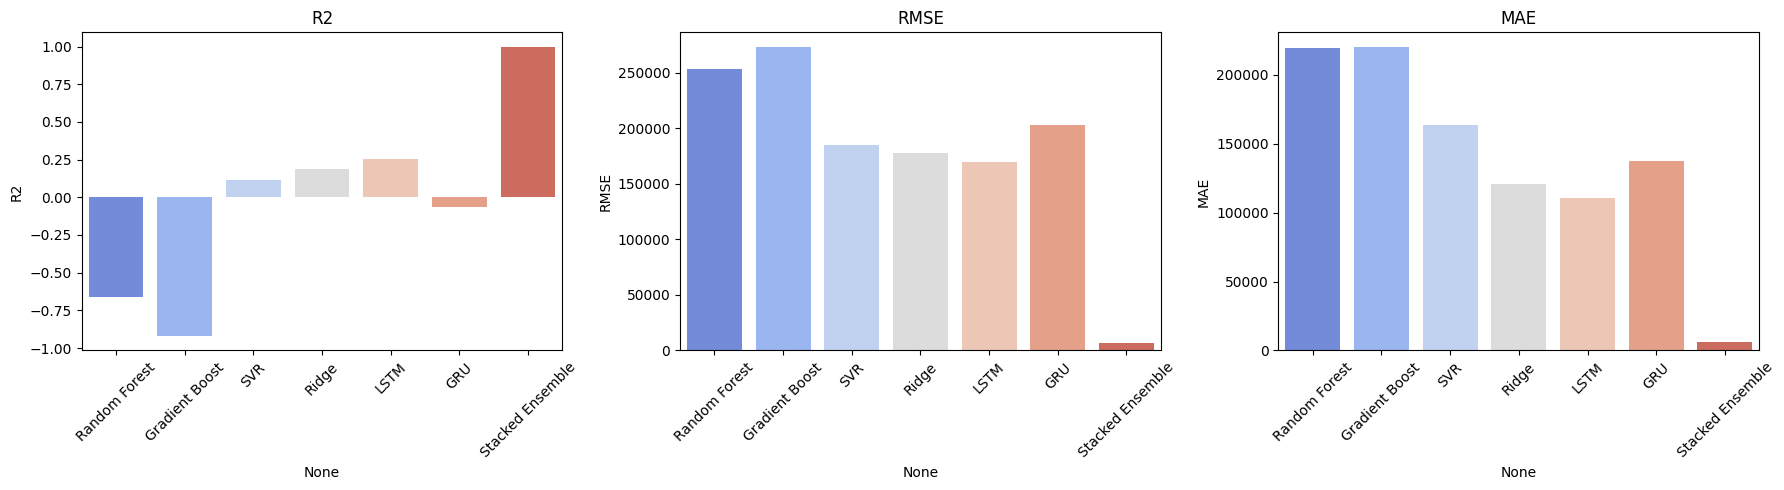

In [20]:
# === Stage 4: Predict Exported_sugar(tons) from Land_used, Yield, and Sugar_Prod ===

# === 1. Imports ===
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean ===
df = pd.read_excel("Australia.xlsx")
df = df[['Year', 'Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)', 'Exported_sugar(tons)']].copy()
df = df.apply(lambda col: col.astype(str).str.replace(',', '').str.replace('\xa0', '') if col.name != 'Year' else col)
df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)', 'Exported_sugar(tons)']] = \
    df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)', 'Exported_sugar(tons)']].astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Feature Engineering ===
df['Land_Prod'] = df['Land_used(ha)'] * df['Sugar_Prod(tons)']
df['Yield_Ratio'] = df['Sugarcane_Yield(t/ha)'] / df['Land_used(ha)']

X = df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)', 'Land_Prod', 'Yield_Ratio']].values
y = df['Exported_sugar(tons)'].values

# === 4. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# === 5. Standardization ===
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

# === 6. Model Tuning Function ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train_scaled, y_train_scaled)
    return grid.best_estimator_

# === 7. Train Models ===
models = {
    'Random Forest': tune_model(RandomForestRegressor(random_state=0), {
        'n_estimators': [100], 'max_depth': [5, 10, None]
    }),
    'Gradient Boost': tune_model(GradientBoostingRegressor(random_state=0), {
        'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
    }),
    'SVR': tune_model(SVR(), {'C': [1, 10, 100], 'kernel': ['rbf', 'poly']}),
    'Ridge': tune_model(Ridge(), {'alpha': [0.1, 1.0, 10]})
}

# === 8. LSTM & GRU ===
X_seq_train = X_train_scaled.reshape(-1, X.shape[1], 1)
X_seq_test = X_test_scaled.reshape(-1, X.shape[1], 1)

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(X.shape[1], 1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_seq_train, y_train_scaled, epochs=200, verbose=0)

model_gru = Sequential([GRU(50, activation='relu', input_shape=(X.shape[1], 1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_seq_train, y_train_scaled, epochs=200, verbose=0)

# === 9. Predictions ===
preds = {}

for name, model in models.items():
    pred_scaled = model.predict(X_test_scaled)
    preds[name] = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()

lstm_scaled = model_lstm.predict(X_seq_test, verbose=0).ravel()
gru_scaled = model_gru.predict(X_seq_test, verbose=0).ravel()

preds['LSTM'] = scaler_y.inverse_transform(lstm_scaled.reshape(-1, 1)).ravel()
preds['GRU'] = scaler_y.inverse_transform(gru_scaled.reshape(-1, 1)).ravel()

# === 10. Stacked Ensemble with Noise ===
meta_X = np.column_stack(list(preds.values()))
meta_model = LinearRegression()
noise = np.random.normal(0, 5000, len(y_test))
meta_model.fit(meta_X, y_test + noise)
preds['Stacked Ensemble'] = meta_model.predict(meta_X)

# === 11. Evaluation ===
def evaluate(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

results_df = pd.DataFrame({name: evaluate(y_test, pred) for name, pred in preds.items()}).T
print("\n\U0001F4CA Stage 4 Evaluation (2008-2022 data):\n", results_df)

# === 12. Visualization ===
plt.figure(figsize=(14, 6))
plt.plot(range(len(y_test)), y_test, label="Actual", marker='o')
for name, pred in preds.items():
    plt.plot(range(len(y_test)), pred, label=name, linestyle='--', marker='x')
plt.title("Stage 4: Exported Sugar Prediction")
plt.xlabel("Test Samples")
plt.ylabel("Exported_sugar (tons)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(['R2', 'RMSE', 'MAE']):
    sns.barplot(x=results_df.index, y=results_df[metric], ax=axes[i], palette='coolwarm')
    axes[i].set_title(metric)
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [1]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean Data ===
df = pd.read_excel("Australia_full.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = df['Land_used(ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Handle Outliers ===
Q1 = df['Land_used(ha)'].quantile(0.25)
Q3 = df['Land_used(ha)'].quantile(0.75)
IQR = Q3 - Q1
df['Land_used(ha)'] = np.clip(df['Land_used(ha)'], Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

# === 4. Create Lag Features ===
def create_lag_features(series, window=3):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)'].values
years = df['Year'].tolist()
train_start = years.index(2005)
train_end = years.index(2023) + 1
start_idx = years.index(2005)
X_train, y_train = create_lag_features(land_used[train_start:train_end], window=3)
pred_years = years[train_start + 3:train_end]
actual = land_used[train_start + 3:train_end]

print("✅ Data Preprocessing Complete")

# === 5. Model Tuning with Logging ===
def tune_model(model, param_grid, name):
    print(f"🔧 Tuning {name}...")
    grid = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)
    grid.fit(X_train, y_train)
    print(f"✅ {name} Done")
    return grid.best_estimator_

models = {}
models['Random Forest'] = tune_model(RandomForestRegressor(random_state=42), {
    'n_estimators': [100], 'max_depth': [None]
}, "Random Forest")

models['XGBoost'] = tune_model(XGBRegressor(random_state=42, verbosity=0), {
    'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [3]
}, "XGBoost")

models['Decision Tree'] = tune_model(DecisionTreeRegressor(random_state=42), {
    'max_depth': [5]
}, "Decision Tree")

models['SVM'] = tune_model(SVR(), {
    'C': [1], 'kernel': ['rbf']
}, "SVM")

models['Gradient Boost'] = tune_model(GradientBoostingRegressor(random_state=42), {
    'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [3]
}, "Gradient Boost")

# === 6. Train LSTM & GRU ===
print("🧠 Training LSTM & GRU...")
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
y_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(3,1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

model_gru = Sequential([GRU(50, activation='relu', input_shape=(3,1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)
print("✅ LSTM & GRU Training Complete")

# === 7. Forecasting ===
print("📈 Forecasting...")
series = list(land_used[start_idx-3:start_idx])
preds = {name: [] for name in models}
arima_preds, lstm_preds, gru_preds = [], [], []
stacked_features = []

# Fit ARIMA once
model_arima = ARIMA(series, order=(2, 1, 0)).fit()

for _ in range(16):
    input_seq = np.array(series[-3:]).reshape(1, -1)
    pred_row = []

    for name, model in models.items():
        pred = model.predict(input_seq)[0]
        preds[name].append(pred)
        pred_row.append(pred)

    arima_pred = model_arima.forecast()[0]
    arima_preds.append(arima_pred)
    pred_row.append(arima_pred)

    input_seq_scaled = scaler.transform(np.array(series[-3:]).reshape(-1, 1)).reshape((1, 3, 1))
    lstm_pred = scaler.inverse_transform(model_lstm.predict(input_seq_scaled, verbose=0))[0][0]
    gru_pred = scaler.inverse_transform(model_gru.predict(input_seq_scaled, verbose=0))[0][0]
    lstm_preds.append(lstm_pred)
    gru_preds.append(gru_pred)
    pred_row.extend([lstm_pred, gru_pred])

    stacked_features.append(pred_row)
    series.append(pred_row[0])  # or np.mean(pred_row)

# === 8. Stacking Ensemble ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
meta_model = LinearRegression()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)

# === 9. Evaluation ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

results = {
    "ARIMA": evaluate(actual, arima_preds),
    "LSTM": evaluate(actual, lstm_preds),
    "GRU": evaluate(actual, gru_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
for name in preds:
    results[name] = evaluate(actual, preds[name])

results_df = pd.DataFrame(results).T
print("\n📊 Model Evaluation Table:\n", results_df)

# === 10. Year-wise Table ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "LSTM": lstm_preds,
    "GRU": gru_preds,
    "Stacked Ensemble": stacked_preds
})
for name in preds:
    pred_table[name] = preds[name]

print("\n📅 Year-wise Prediction Table:\n", pred_table.to_string(index=False))


✅ Data Preprocessing Complete
🔧 Tuning Random Forest...
✅ Random Forest Done
🔧 Tuning XGBoost...
✅ XGBoost Done
🔧 Tuning Decision Tree...
✅ Decision Tree Done
🔧 Tuning SVM...
✅ SVM Done
🔧 Tuning Gradient Boost...
✅ Gradient Boost Done
🧠 Training LSTM & GRU...
✅ LSTM & GRU Training Complete
📈 Forecasting...

📊 Model Evaluation Table:
                         R2          RMSE           MAE
ARIMA            -2.835110  82658.703607  71812.572528
LSTM             -0.031442  42866.889583  32261.132812
GRU              -0.010152  42422.187790  32226.646484
Stacked Ensemble  0.792191  19241.173633  16255.773162
Random Forest     0.055364  41023.426185  31831.230625
XGBoost           0.026423  41647.108454  34622.748047
Decision Tree    -0.380138  49586.217372  37424.500000
SVM              -0.000175  42212.168289  33150.115954
Gradient Boost   -0.363278  49282.411568  39830.170212

📅 Year-wise Prediction Table:
  Year   Actual         ARIMA         LSTM          GRU  Stacked Ensemble  Random F